# Imports

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple, List
from cryptovision.tools import (
    image_directory_to_pandas,
    split_image_dataframe,
    tf_dataset_from_pandas,
    predict_image,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-12-11 17:03:57.340 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


# Tools

In [5]:
def load_image(img_path: str, img_size: Tuple[int, int] = (224, 224)) -> np.ndarray:
    """
    Loads and preprocesses an image for TensorFlow model predictions.

    Parameters:
        img_path (str): The path to the image file.
        img_size (Tuple[int, int]): Target size (height, width) for resizing the image.

    Returns:
        np.ndarray: Preprocessed image array with shape (1, height, width, channels).
    
    Raises:
        FileNotFoundError: If the image file does not exist.
        ValueError: If the input image cannot be processed.
    """
    try:
        # Load the image with the specified target size
        img = load_img(img_path, target_size=img_size)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Image file not found: {img_path}") from e
    except Exception as e:
        raise ValueError(f"Failed to load the image: {e}") from e

    try:
        # Convert the image to a NumPy array
        img_array = img_to_array(img)
        
        # Add a batch dimension to the image array
        img_array = np.expand_dims(img_array, axis=0)
    except Exception as e:
        raise ValueError(f"Failed to preprocess the image: {e}") from e

    return img_array

def decode_predictions(pred: np.ndarray, labels: List[str], top_k: int = 1) -> List[Tuple[str, int, float]]:
    """
    Decodes the predictions by mapping indices to labels and returning the top predictions.

    Parameters:
        pred (np.ndarray): Array of prediction probabilities (1D or 2D with shape `(1, num_classes)`).
        labels (List[str]): List of labels corresponding to the prediction indices.
        top_k (int): Number of top predictions to return.

    Returns:
        List[Tuple[str, int, float]]: List of tuples containing label, index, and confidence score for the top predictions.
    
    Raises:
        ValueError: If the shapes of `pred` and `labels` do not match or if invalid inputs are provided.
    """
    # Ensure pred is a 2D array for consistency
    if pred.ndim == 1:
        pred = np.expand_dims(pred, axis=0)

    # Validate the input shapes
    if pred.shape[1] != len(labels):
        raise ValueError("The number of prediction classes must match the number of labels.")
    
    # Get the top_k predictions
    top_indices = np.argsort(pred[0])[::-1][:top_k]
    top_predictions = [(labels[idx], idx, pred[0][idx]) for idx in top_indices]
    
    return top_predictions

def calculate_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

# Variables

In [6]:
IMAGES_DATASET_PATH = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset'
TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras'

SEED = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15
BATCH_SIZE = 64


# Setup

In [7]:
CV_MODEL = tf.keras.models.load_model(TRAINED_MODEL_PATH)

IMAGE_SIZE = CV_MODEL.input_shape[1:3]

df_images = image_directory_to_pandas(IMAGES_DATASET_PATH)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    random_state=SEED,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

test_ds, _, _, _ = tf_dataset_from_pandas(test_df, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False)


2024-12-11 17:03:59.043530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-11 17:03:59.043578: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-11 17:03:59.043586: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-11 17:03:59.043607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 17:03:59.043626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize
import numpy as np
import random

def plot_saliency(level, idx, labels_names):
    """
    Plots the original image, saliency map, and saliency overlay for a given level and image index.

    Parameters:
        level (str): The output level to visualize (e.g., 'family', 'genus', 'species').
        idx (int): Index of the image in the test DataFrame.
        species_labels (list): List of species labels to decode predictions.
    """
    # Create a model that outputs the desired level's predictions
    model = tf.keras.models.Model(
        inputs=CV_MODEL.inputs,
        outputs=CV_MODEL.get_layer(level).output
    )

    # If model has a softmax and we need a linear output layer for visualization
    model_modifier = ReplaceToLinear()

    # Select an image from test_df
    random_image_path = test_df['image_path'].values[idx]

    # Load and preprocess the image
    img = load_img(random_image_path, target_size=(384, 384))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, ) + img_array.shape)  # (1, 384, 384, 3)

    # Make predictions
    preds = CV_MODEL.predict(img_array)
    if level == 'family':
        pred_class = np.argmax(preds[0])  # Assuming 'family' is at index 0 for predictions
    elif level == 'genus':
        pred_class = np.argmax(preds[1])  # Assuming 'genus' is at index 1 for predictions
    else:
        pred_class = np.argmax(preds[2])  # Assuming 'species' is at index 2 for predictions
    pred_label = labels_names[pred_class]

    # Define class index for saliency
    class_index = np.argmax(preds[2])
    score = CategoricalScore([class_index])

    # Create and compute saliency map
    saliency = Saliency(model, model_modifier=model_modifier, clone=False)
    saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.20)
    saliency_map = normalize(saliency_map)

    # Get the true label from test_df
    true_label = test_df.iloc[idx][level]

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Predicted: {pred_label} - {preds[2].max():.3f} | True: {true_label}", fontsize=16)

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    # Saliency map
    plt.subplot(1, 3, 2)
    plt.title("Saliency Map")
    plt.imshow(saliency_map[0], cmap='jet')
    plt.axis('off')

    # Saliency overlay (maintaining saliency coloration)
    plt.subplot(1, 3, 3)
    plt.title("Saliency Overlay")
    plt.imshow(img)
    plt.imshow(saliency_map[0], cmap='jet', alpha=0.5)  # Overlay saliency map with transparency
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    
idx = random.randint(0, 1354)

print(f"Print {idx}")

plot_saliency(
    'species', 
    625,
    #random.randint(0, 1354), 
    species_labels
) #309 399 249 765 853 1084 167 15 20

Print 1117
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
from tqdm import tqdm
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency

class CryptoVisionAI:
    def __init__(self, model_path, family_names, genus_names, species_names):
        """
        Initializes the CryptoVisionAI class.
        
        Parameters:
            model (tf.keras.Model): The trained model for prediction.
            family_names (list): List of family label names.
            genus_names (list): List of genus label names.
            species_names (list): List of species label names.
        """
        self.model = tf.keras.models.load_model(model_path)
        self.family_names = family_names
        self.genus_names = genus_names
        self.species_names = species_names
        self.target_size = self.model.input_shape[1:3]
    
    @property  
    def image(self):
        return tf.keras.preprocessing.image.load_img(self.image_path, target_size=self.target_size)    
    
    @property
    def family_model(self):
        if not hasattr(self, '_family_model'):
            self._family_model = tf.keras.models.Model(
                inputs=self.model.input,
                outputs=self.model.get_layer('family').output
            )
        return self._family_model
    
    @property
    def genus_model(self):
        if not hasattr(self, '_genus_model'):
            self._genus_model = tf.keras.models.Model(
                inputs=self.model.input,
                outputs=self.model.get_layer('genus').output
            )
        return self._genus_model
    
    @property
    def species_model(self):
        if not hasattr(self, '_species_model'):
            self._species_model = tf.keras.models.Model(
                inputs=self.model.input,
                outputs=self.model.get_layer('species').output
            )
        return self._species_model
    
    @property
    def image_array(self):
        try:
            image_array = tf.keras.preprocessing.image.img_to_array(self.image)
            image_array = np.expand_dims(image_array, axis=0)
            return image_array
        except Exception as e:
            print(f"Error processing image at {self.image_path}: {e}")
            return None

    def decoder(self, preds):
        try:
            family_pred = self.family_names[np.argmax(preds[0])] if preds[0] is not None else "Unknown"
            genus_pred = self.genus_names[np.argmax(preds[1])] if preds[1] is not None else "Unknown"
            species_pred = self.species_names[np.argmax(preds[2])] if preds[2] is not None else "Unknown"
            return [family_pred, genus_pred, species_pred]
        except IndexError:
            return ["Unknown", "Unknown", "Unknown"]
    
    def complete_prediction(self, preds):
        """
        Predicts labels for a single image.

        Parameters:
            image (np.array): Preprocessed image.
            return_probabilities (bool): Whether to return probabilities.

        Returns:
            list: Predicted labels.
        """
        
        results = {
            'family': {},
            'genus': {},
            'species': {},
        }
        
        family_pred = np.argmax(preds[0])
        genus_pred = np.argmax(preds[1])
        species_pred = np.argmax(preds[2])
        
        family_label, genus_label, species_label = self.decoder(preds)
        
        # Return the predicted names
        results['family']['name'] = family_label
        results['genus']['name'] = genus_label
        results['species']['name'] = species_label
        
        # Return the predicted labels
        results['family']['label'] = family_pred
        results['genus']['label'] = genus_pred
        results['species']['label'] = species_pred
        
        # Return the predicted probabilities
        results['family']['prob'] = preds[0].max()
        results['genus']['prob'] = preds[1].max()
        results['species']['prob'] = preds[2].max()
        
        return results

    def predict_from_path(self, image_path, prediction_type='labels'):
        """
        Predicts labels from a list of image paths.
        
        Parameters:
            image_paths (list): List of image paths.
            batch_size (int): Size of batches for prediction.
        
        Returns:
            list: Predictions for all images.
        """
        results = []
        self.image_path = image_path
        preds = self.model.predict(self.image_array, verbose=0)
        if prediction_type == 'complete':
            return self.complete_prediction(preds)
        elif prediction_type == 'raw':
            return preds
        elif prediction_type == 'labels':
            return self.decoder(preds)

    def predict_from_dataframe(self, dataframe, reference_column, batch_size=64):
        """
        Predicts labels from a pandas DataFrame with image paths in batches, with progress tracking.
        
        Parameters:
            dataframe (pd.DataFrame): DataFrame containing image paths and metadata.
            reference_column (str): Column containing the image paths.
            batch_size (int): Number of images to process per batch.
        
        Returns:
            list: List of predictions for all images.
        """
        predictions = []
        num_batches = (len(dataframe) + batch_size - 1) // batch_size  # Calculate the total number of batches

        with tqdm(total=num_batches, desc="Predicting Batches") as pbar:
            for i in range(0, len(dataframe), batch_size):
                batch_df = dataframe.iloc[i:i + batch_size]
                batch_images = np.vstack([self.image_path_to_array(row[reference_column]) for _, row in batch_df.iterrows()])
                batch_preds = self.model.predict(batch_images, verbose=0)
                decoded_batch = [
                    self.decoder([batch_preds[0][i], batch_preds[1][i], batch_preds[2][i]]) 
                    for i in range(len(batch_preds[0]))
                ]
                predictions.extend(decoded_batch)
                pbar.update(1)
        
        return predictions

    def predict_from_tf_dataset(self, tf_dataset):
        """
        Predicts labels from a TensorFlow dataset.

        Parameters:
            tf_dataset (tf.data.Dataset): Dataset containing images and labels.

        Returns:
            list: Decoded predictions for all images in the dataset.
        """
        predictions = []
        for batch in tqdm(tf_dataset, desc="Predicting with Dataset"):
            img_batch, _ = batch  # Assuming labels are the second element
            preds = self.model.predict(img_batch, verbose=0)
            
            # Decode predictions for the batch
            decoded_batch = [
                self.decoder([preds[0][i], preds[1][i], preds[2][i]]) 
                for i in range(len(preds[0]))
            ]
            predictions.extend(decoded_batch)
            
        return predictions
    
    def saliency_map(self, level, image_path, figure_size = (15, 8)):
        
        self.image_path = image_path
        preds = self.model.predict(self.image_array, verbose=0)
        preds = self.complete_prediction(preds)
        class_index = preds[level]['label']
        
        if level == 'family':
            model = self.family_model
        elif level == 'genus':
            model = self.genus_model
        elif level == 'species':
            model = self.species_model
            
        score = CategoricalScore([class_index])
        saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=False)
        saliency_map = saliency(score, self.image_array, smooth_samples=20, smooth_noise=0.2)
        saliency_map = normalize(saliency_map)
        
        # Plot results
        plt.figure(figsize=figure_size)
        plt.suptitle(f"Predicted Class: {preds[level]['name']} - {preds[level]['prob']*100:.2f}%", fontsize=14)
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(self.image)
        plt.axis('off')
        
        # Saliency Map
        plt.subplot(1, 3, 2)
        plt.title("Saliency Map")
        plt.imshow(saliency_map[0], cmap='jet')
        plt.axis('off')
        
        # Saliency overlay
        plt.subplot(1, 3, 3)
        plt.title("Saliency Overlay")
        plt.imshow(self.image)
        plt.imshow(saliency_map[0], cmap='jet', alpha=0.5)  # Overlay saliency map with transparency
        plt.axis('off')
        
        pass

    

# Instantiate the class
ai = CryptoVisionAI(
    model_path=TRAINED_MODEL_PATH,
    family_names=family_labels,
    genus_names=genus_labels,
    species_names=species_labels,
)


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [98]:
image_path = test_df['image_path'].values[0]

preds = ai.predict_from_path(image_path, 'raw')
preds

[array([[7.453e-04, 7.238e-04, 7.181e-04, 2.180e-03, 1.651e-03, 3.054e-04,
         2.800e-03, 8.217e-03, 8.450e-04, 1.978e-02, 2.342e-03, 3.591e-04,
         6.170e-04, 2.252e-02, 2.265e-04, 2.802e-03, 9.316e-01, 1.381e-03]],
       dtype=float16),
 array([[5.132e-05, 3.684e-05, 1.293e-05, 9.766e-01, 8.980e-03, 6.652e-05,
         7.658e-04, 4.718e-04, 2.009e-05, 4.973e-04, 2.223e-05, 9.000e-05,
         1.510e-04, 2.390e-04, 4.530e-06, 2.376e-04, 1.502e-04, 1.792e-04,
         2.891e-05, 1.808e-03, 2.811e-04, 1.467e-03, 8.899e-05, 1.836e-05,
         2.446e-04, 2.348e-05, 3.574e-04, 1.901e-05, 3.862e-04, 1.030e-04,
         5.561e-05, 2.004e-04, 7.063e-05, 7.814e-05, 6.062e-05, 2.760e-03,
         1.421e-03, 9.263e-05, 2.331e-05, 6.070e-04, 1.556e-05, 5.360e-04,
         2.759e-04, 2.068e-05, 2.189e-04]], dtype=float16),
 array([[9.120e-06, 2.146e-05, 2.384e-06, 2.897e-05, 9.927e-01, 8.793e-04,
         2.235e-05, 1.469e-04, 2.593e-05, 1.580e-05, 3.707e-04, 4.411e-06,
         2.346e

In [88]:
# Create a new column to flag the source of the image
def flag_image_source(df, column_name="image_path", new_column="image_source"):
    """
    Flags the source of each image based on its path.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the image path column.
        column_name (str): The column name containing image paths.
        new_column (str): The name of the new column to be added for flagging.

    Returns:
        pd.DataFrame: DataFrame with the new column indicating image source.
    """
    # Apply a function to determine the source based on keywords in the image path
    df[new_column] = df[column_name].apply(
        lambda x: "internet" if "web" in x.lower() else ("lab" if "sjb" in x.lower() else "unknown")
    )
    return df

# Apply the function to the test DataFrame
test_df = flag_image_source(test_df, column_name="image_path", new_column="image_source")

# Display the updated DataFrame to confirm the changes
test_df['image_source'].value_counts()

image_source
internet    1058
lab          296
Name: count, dtype: int64

In [89]:
# Split the test dataset by source
internet_images = test_df[test_df['image_source'] == 'internet']
lab_images = test_df[test_df['image_source'] == 'lab']

print(f"Internet Images: {len(internet_images)}, Lab Images: {len(lab_images)}")

from sklearn.metrics import classification_report

Internet Images: 1058, Lab Images: 296


In [88]:
from sklearn.metrics import classification_report

def evaluate_source_performance(source_df, all_true, all_pred, level="species"):
    """
    Evaluate the model's performance for a specific image source.
    
    Parameters:
        source_df (pd.DataFrame): DataFrame containing images from a specific source.
        all_true (list): List of true labels for the level.
        all_pred (list): List of predicted labels for the level.
        level (str): The level of analysis (e.g., "species", "genus", or "family").

    Returns:
        dict: A dictionary with performance metrics for the source.
    """
    # Filter predictions and true labels by source indices
    indices = source_df.index.tolist()
    source_true = [all_true[i] for i in indices]
    source_pred = [all_pred[i] for i in indices]

    # Generate classification report
    report = classification_report(source_true, source_pred, output_dict=True)
    return report

# Evaluate performance for internet and lab images at the species level
internet_performance = evaluate_source_performance(internet_images, all_true_species, all_pred_species, level="species")
lab_performance = evaluate_source_performance(lab_images, all_true_species, all_pred_species, level="species")

print("Internet Image Performance (Species Level):")
print(internet_performance)

print("Lab Image Performance (Species Level):")
print(lab_performance)

Internet Image Performance (Species Level):
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14.0}, '3': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.9230769230769231, 'support': 18.0}, '4': {'precision': 0.9821428571428571, 'recall': 1.0, 'f1-score': 0.990990990990991, 'support': 55.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '7': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 14.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 41.0}, '10': {'precision': 0.9772727272727273, 'recall': 0.9555555555555556, 'f1-score': 0.9662921348314607, 'support': 45.0}, '11': {'p

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [86]:
import pandas as pd

def compare_performance(internet_perf, lab_perf):
    """
    Compare performance metrics between internet and lab images.

    Parameters:
        internet_perf (dict): Performance metrics for internet images.
        lab_perf (dict): Performance metrics for lab images.

    Returns:
        pd.DataFrame: DataFrame comparing metrics side-by-side.
    """
    metrics = ["accuracy", "precision", "recall", "f1-score"]
    comparison = pd.DataFrame({
        "Metric": metrics,
        "Internet": [internet_perf["accuracy"], 
                     internet_perf["weighted avg"]["precision"], 
                     internet_perf["weighted avg"]["recall"], 
                     internet_perf["weighted avg"]["f1-score"]],
        "Lab": [lab_perf["accuracy"], 
                lab_perf["weighted avg"]["precision"], 
                lab_perf["weighted avg"]["recall"], 
                lab_perf["weighted avg"]["f1-score"]]
    })
    return comparison

comparison_df = compare_performance(internet_performance, lab_performance)
print(comparison_df)

      Metric  Internet       Lab
0   accuracy  0.939509  0.942568
1  precision  0.944598  0.955849
2     recall  0.939509  0.942568
3   f1-score  0.939023  0.943942


# Metrics Report

In [121]:
all_true_families, all_pred_families = [], []
all_true_genus, all_pred_genus = [], []
all_true_species, all_pred_species = [], []
all_true, all_pred = [], []

all_conf_family, all_conf_genus, all_conf_species = [], [], []

for batch in test_ds:
    
    # Extract batch data
    images, labels = batch
    
    # Extract true labels
    true_family = tf.argmax(labels['family'], axis=1).numpy()
    true_genus = tf.argmax(labels['genus'], axis=1).numpy()
    true_species = tf.argmax(labels['species'], axis=1).numpy()
    
    # Predict and extract predicted labels
    preds = CV_MODEL.predict(images, verbose=0)
    pred_family = tf.argmax(preds[0], axis=1).numpy()
    pred_genus = tf.argmax(preds[1], axis=1).numpy()
    pred_species = tf.argmax(preds[2], axis=1).numpy()
    
    all_conf_family.append(preds[0])
    all_conf_genus.append(preds[1])
    all_conf_species.append(preds[2])
    
    # Append to respective lists
    all_true_families.extend(true_family)
    all_pred_families.extend(pred_family)
    all_true_genus.extend(true_genus)
    all_pred_genus.extend(pred_genus)
    all_true_species.extend(true_species)
    all_pred_species.extend(pred_species)
    
# All true labels Overall
all_true.extend(all_true_families)
all_true.extend(all_true_genus)
all_true.extend(all_true_species)

# All predicted labels Overall
all_pred.extend(all_pred_families)
all_pred.extend(all_pred_genus)
all_pred.extend(all_pred_species)

2024-12-10 11:11:11.564513: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [100]:
import pprint

metrics = {}

metrics['overall'] = calculate_metrics(all_true, all_pred)
metrics['family'] = calculate_metrics(all_true_families, all_pred_families)
metrics['genus'] = calculate_metrics(all_true_genus, all_pred_genus)
metrics['species'] = calculate_metrics(all_true_species, all_pred_species)

pprint.pprint(metrics)

{'family': {'accuracy': 0.9593796159527327,
            'f1_score': 0.9589292862066104,
            'precision': 0.9600381027301136,
            'recall': 0.9593796159527327},
 'genus': {'accuracy': 0.946824224519941,
           'f1_score': 0.946974092600686,
           'precision': 0.9516198113353878,
           'recall': 0.946824224519941},
 'overall': {'accuracy': 0.9487936976858691,
             'f1_score': 0.9487866190415859,
             'precision': 0.9499819794635926,
             'recall': 0.9487936976858691},
 'species': {'accuracy': 0.9401772525849336,
             'f1_score': 0.9393216316758887,
             'precision': 0.9432341154625802,
             'recall': 0.9401772525849336}}


In [28]:
import tensorflow as tf
import numpy as np

def calculate_top_k_accuracy(model, test_ds, k=3):
    """
    Calculate the top-k accuracy for a hierarchical classification model.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        k (int): The value of k for top-k accuracy.

    Returns:
        dict: A dictionary containing top-k accuracy for Family, Genus, and Species levels.
    """
    # Initialize counters
    total_samples_family, top_k_correct_family = 0, 0
    total_samples_genus, top_k_correct_genus = 0, 0
    total_samples_species, top_k_correct_species = 0, 0

    for batch in test_ds:
        images, labels = batch
        
        # Extract true labels
        true_family = tf.argmax(labels['family'], axis=1).numpy()
        true_genus = tf.argmax(labels['genus'], axis=1).numpy()
        true_species = tf.argmax(labels['species'], axis=1).numpy()
        
        # Predict probabilities for each output
        preds = model.predict(images, verbose=0)
        
        # Calculate top-k indices
        top_k_family = np.argsort(preds[0], axis=1)[:, -k:]  # Top-k for family
        top_k_genus = np.argsort(preds[1], axis=1)[:, -k:]   # Top-k for genus
        top_k_species = np.argsort(preds[2], axis=1)[:, -k:] # Top-k for species
        
        # Check if true labels are within the top-k indices
        for idx, true_label in enumerate(true_family):
            if true_label in top_k_family[idx]:
                top_k_correct_family += 1
            total_samples_family += 1
        
        for idx, true_label in enumerate(true_genus):
            if true_label in top_k_genus[idx]:
                top_k_correct_genus += 1
            total_samples_genus += 1
        
        for idx, true_label in enumerate(true_species):
            if true_label in top_k_species[idx]:
                top_k_correct_species += 1
            total_samples_species += 1

    # Calculate top-k accuracy for each level
    family_top_k_accuracy = top_k_correct_family / total_samples_family
    genus_top_k_accuracy = top_k_correct_genus / total_samples_genus
    species_top_k_accuracy = top_k_correct_species / total_samples_species

    return {
        "family_top_k_accuracy": family_top_k_accuracy,
        "genus_top_k_accuracy": genus_top_k_accuracy,
        "species_top_k_accuracy": species_top_k_accuracy
    }

In [29]:
top_k_metrics = calculate_top_k_accuracy(model=CV_MODEL, test_ds=test_ds, k=3)
print(top_k_metrics)

{'family_top_k_accuracy': 0.9940915805022157, 'genus_top_k_accuracy': 0.9867060561299852, 'species_top_k_accuracy': 0.9867060561299852}


2024-12-09 15:01:48.392911: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
print(f"""
    Performance Report:
    -------------------
    Family:
        Accuracy: {metrics['family']['accuracy']:.3f}
        Accuracy Top3: {top_k_metrics['family_top_k_accuracy']:.3f}
    Genus:
        Accuracy: {metrics['genus']['accuracy']:.3f}
        Accuracy Top3: {top_k_metrics['genus_top_k_accuracy']:.3f}
    Species:
        Accuracy: {metrics['species']['accuracy']:.3f}
        Accuracy Top3: {top_k_metrics['species_top_k_accuracy']:.3f}
""")


    Performance Report:
    -------------------
    Family:
        Accuracy: 0.959
        Accuracy Top3: 0.994
    Genus:
        Accuracy: 0.947
        Accuracy Top3: 0.987
    Species:
        Accuracy: 0.940
        Accuracy Top3: 0.987



In [31]:
def calculate_confidence_stats(y_true: np.ndarray, y_pred: np.ndarray, y_probs: np.ndarray) -> dict:
    """
    Calculates average confidence and standard deviation for correct and incorrect predictions.

    Parameters:
        y_true (np.ndarray): Ground truth labels.
        y_pred (np.ndarray): Predicted labels.
        y_probs (np.ndarray): Prediction probabilities (2D array with shape `(num_samples, num_classes)`).

    Returns:
        dict: Dictionary with average confidence and standard deviation for correct and incorrect predictions.
    """
    if y_probs.shape[0] != len(y_true):
        raise ValueError("Mismatch between the number of samples in y_true and y_probs.")

    # Ensure y_probs contains probabilities for each sample
    confidences = np.max(y_probs, axis=1)  # Maximum probability for each prediction

    # Split into correct and incorrect predictions
    correct_confidences = confidences[y_true == y_pred]
    incorrect_confidences = confidences[y_true != y_pred]

    # Calculate statistics
    stats = {
        "correct": {
            "mean_confidence": np.mean(correct_confidences),
            "std_confidence": np.std(correct_confidences),
        },
        "incorrect": {
            "mean_confidence": np.mean(incorrect_confidences),
            "std_confidence": np.std(incorrect_confidences),
        },
    }

    return stats

# Example usage
# Assuming you have y_true, y_pred, and y_probs from your model's predictions
# y_true: Ground truth labels (1D array of integers)
# y_pred: Predicted labels (1D array of integers)
# y_probs: Prediction probabilities (2D array with shape [num_samples, num_classes])

stats = calculate_confidence_stats(
    np.array(all_true_families), 
    np.array(all_pred_families), 
    np.concatenate(all_conf_family, axis=0)
)
print("Confidence Statistics Family:")
print(f"Correct Predictions: Mean={stats['correct']['mean_confidence']:.4f}, Std={stats['correct']['std_confidence']:.4f}")
print(f"Incorrect Predictions: Mean={stats['incorrect']['mean_confidence']:.4f}, Std={stats['incorrect']['std_confidence']:.4f}")

conf_limit = (
    stats['correct']['mean_confidence']-stats['correct']['std_confidence']
    +stats['incorrect']['mean_confidence']+stats['incorrect']['std_confidence']
)/2

print(f"Confidence limit: {conf_limit:.3f}")

Confidence Statistics Family:
Correct Predictions: Mean=0.9058, Std=0.1240
Incorrect Predictions: Mean=0.5415, Std=0.1749
Confidence limit: 0.749


In [32]:
stats = calculate_confidence_stats(
    np.array(all_true_genus), 
    np.array(all_pred_genus), 
    np.concatenate(all_conf_genus, axis=0)
)
print("Confidence Statistics Genus:")
print(f"Correct Predictions: Mean={stats['correct']['mean_confidence']:.4f}, Std={stats['correct']['std_confidence']:.4f}")
print(f"Incorrect Predictions: Mean={stats['incorrect']['mean_confidence']:.4f}, Std={stats['incorrect']['std_confidence']:.4f}")

conf_limit = (
    stats['correct']['mean_confidence']-stats['correct']['std_confidence']
    +stats['incorrect']['mean_confidence']+stats['incorrect']['std_confidence']
)/2

print(f"Confidence limit: {conf_limit:.3f}")

Confidence Statistics Genus:
Correct Predictions: Mean=0.9243, Std=0.1259
Incorrect Predictions: Mean=0.4907, Std=0.2000
Confidence limit: 0.745


In [33]:
stats = calculate_confidence_stats(
    np.array(all_true_species), 
    np.array(all_pred_species), 
    np.concatenate(all_conf_species, axis=0)
)
print("Confidence Statistics Species:")
print(f"Correct Predictions: Mean={stats['correct']['mean_confidence']:.4f}, Std={stats['correct']['std_confidence']:.4f}")
print(f"Incorrect Predictions: Mean={stats['incorrect']['mean_confidence']:.4f}, Std={stats['incorrect']['std_confidence']:.4f}")

conf_limit = (
    stats['correct']['mean_confidence']-stats['correct']['std_confidence']
    +stats['incorrect']['mean_confidence']+stats['incorrect']['std_confidence']
)/2

print(f"Confidence limit: {conf_limit:.3f}")

Confidence Statistics Species:
Correct Predictions: Mean=0.8965, Std=0.1454
Incorrect Predictions: Mean=0.4729, Std=0.2026
Confidence limit: 0.713


In [34]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef

# Example for Species Level
kappa_species = cohen_kappa_score(all_true_species, all_pred_species)
print(f"Cohen's Kappa for Species Level: {kappa_species:.4f}")

# Example for Species Level
y_probs_species = np.concatenate(all_conf_species, axis=0)  # Predicted probabilities
cross_entropy_species = log_loss(all_true_species, y_probs_species)
print(f"Cross-Entropy Loss for Species Level: {cross_entropy_species:.4f}")

# Example for Species Level
mcc_species = matthews_corrcoef(all_true_species, all_pred_species)
print(f"Matthews Correlation Coefficient for Species Level: {mcc_species:.4f}")

Cohen's Kappa for Species Level: 0.9384
Cross-Entropy Loss for Species Level: 0.2956
Matthews Correlation Coefficient for Species Level: 0.9384


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2969: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [8]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

def perclass_metrics(model, test_ds, family_labels, genus_labels, species_labels):
    """
    Collect detailed metrics for each class in Family, Genus, and Species levels.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        family_labels, genus_labels, species_labels (list): Class labels for Family, Genus, and Species.

    Returns:
        dict: A dictionary containing DataFrames for Family, Genus, and Species level metrics.
    """
    all_true_families, all_pred_families = [], []
    all_true_genus, all_pred_genus = [], []
    all_true_species, all_pred_species = [], []

    # Collect predictions and true labels
    for batch in test_ds:
        images, labels = batch

        # Extract true labels
        true_family = tf.argmax(labels['family'], axis=1).numpy()
        true_genus = tf.argmax(labels['genus'], axis=1).numpy()
        true_species = tf.argmax(labels['species'], axis=1).numpy()

        # Predict and extract predicted labels
        preds = model.predict(images, verbose=0)
        pred_family = tf.argmax(preds[0], axis=1).numpy()
        pred_genus = tf.argmax(preds[1], axis=1).numpy()
        pred_species = tf.argmax(preds[2], axis=1).numpy()

        # Append to respective lists
        all_true_families.extend(true_family)
        all_pred_families.extend(pred_family)
        all_true_genus.extend(true_genus)
        all_pred_genus.extend(pred_genus)
        all_true_species.extend(true_species)
        all_pred_species.extend(pred_species)

    # Helper function to calculate class-level metrics
    def calculate_class_metrics(y_true, y_pred, class_labels):
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, labels=range(len(class_labels)), zero_division=0
        )
        # Calculate error percentages
        errors = [np.sum((np.array(y_true) == i) & (np.array(y_pred) != i)) for i in range(len(class_labels))]
        error_percentage = (np.array(errors) / np.array(support)) * 100
        error_percentage[np.isnan(error_percentage)] = 0  # Handle NaNs for classes with no support

        metrics_df = pd.DataFrame({
            "Class": class_labels,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Support": support,
            "Error Percentage": error_percentage
        })
        return metrics_df

    # Generate metrics for each level
    family_metrics_df = calculate_class_metrics(all_true_families, all_pred_families, family_labels)
    genus_metrics_df = calculate_class_metrics(all_true_genus, all_pred_genus, genus_labels)
    species_metrics_df = calculate_class_metrics(all_true_species, all_pred_species, species_labels)

    # Combine results into a dictionary
    second_level_metrics = {
        "family": family_metrics_df,
        "genus": genus_metrics_df,
        "species": species_metrics_df
    }

    return second_level_metrics

In [10]:
pclass_metrics = perclass_metrics(
    model=CV_MODEL,
    test_ds=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
)

for level, metrics_df in pclass_metrics.items():
    print(f"Metrics for {level.capitalize()} level:")
    print(metrics_df.sort_values('Precision').head(5))
    print("\n")

2024-12-11 17:04:22.972324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Metrics for Family level:
             Class  Precision    Recall  F1-Score  Support  Error Percentage
2     Chaenopsidae   0.818182  0.692308  0.750000       13         30.769231
8      Plesiopidae   0.857143  0.857143  0.857143       14         14.285714
17  Tripterygiidae   0.876543  0.959459  0.916129       74          4.054054
1       Blenniidae   0.921569  0.921569  0.921569       51          7.843137
13    Scorpaenidae   0.929825  1.000000  0.963636       53          0.000000


Metrics for Genus level:
               Class  Precision    Recall  F1-Score  Support  Error Percentage
44              Ucla   0.625000  0.833333  0.714286       18         16.666667
34       Pleurosicya   0.625000  0.625000  0.625000        8         37.500000
0   Acanthemblemaria   0.722222  1.000000  0.838710       13          0.000000
42     Sebastapistes   0.823529  1.000000  0.903226       14          0.000000
15    Enneapterygius   0.833333  0.972222  0.897436       36          2.777778


Metrics f

2024-12-11 17:04:42.753724: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for key in pclass_metrics.keys():
    print(f"Correlation for {key.upper()} level:")
    #print(pclass_metrics[key][["Error Percentage","Support"]].corr())
    print(pclass_metrics[key][['Precision','Recall','F1-Score','Support']].corr()['Support'])
    print("_____________________________________________________________")

Correlation for FAMILY level:
Precision    0.142405
Recall       0.387854
F1-Score     0.389442
Support      1.000000
Name: Support, dtype: float64
_____________________________________________________________
Correlation for GENUS level:
Precision    0.219864
Recall       0.532634
F1-Score     0.527671
Support      1.000000
Name: Support, dtype: float64
_____________________________________________________________
Correlation for SPECIES level:
Precision    0.234170
Recall       0.340678
F1-Score     0.380372
Support      1.000000
Name: Support, dtype: float64
_____________________________________________________________


In [39]:
# Assuming `test_df` is your DataFrame with columns 'family', 'genus', and 'species'
unique_combinations = test_df[['family', 'genus', 'species']].drop_duplicates()

# Create the family_genus_map
family_genus_map = unique_combinations.groupby('family')['genus'].apply(list).to_dict()

# Create the genus_species_map
genus_species_map = unique_combinations.groupby('genus')['species'].apply(list).to_dict()

# Create the family_species_map
family_species_map = unique_combinations.groupby('family')['species'].apply(list).to_dict()

# Print the mappings
print("Family to Genus Map:")
print(family_genus_map)
print("\nGenus to Species Map:")
print(genus_species_map)
print("\nFamily to Species Map:")
print(family_species_map)

Family to Genus Map:
{'Apogonidae': ['Pristiapogon', 'Apogon', 'Apogon', 'Ostorhinchus', 'Fowleria'], 'Blenniidae': ['Ecsenius', 'Cirripectes', 'Ecsenius', 'Enchelyurus'], 'Chaenopsidae': ['Acanthemblemaria'], 'Chaetodontidae': ['Chaetodon'], 'Cirrhitidae': ['Neocirrhites', 'Paracirrhites'], 'Creediidae': ['Limnichthys'], 'Gobiidae': ['Nemateleotris', 'Eviota', 'Priolepis', 'Istigobius', 'Gobiodon', 'Eviota', 'Koumansetta', 'Fusigobius', 'Gobiodon', 'Eviota', 'Paragobiodon', 'Aioliops', 'Trimma', 'Paragobiodon', 'Pleurosicya'], 'Labridae': ['Pseudocheilinus', 'Labroides', 'Halichoeres', 'Pseudocheilinus', 'Gomphosus'], 'Plesiopidae': ['Plesiops'], 'Pomacanthidae': ['Pomacanthus', 'Centropyge', 'Centropyge'], 'Pomacentridae': ['Chromis', 'Pomacentrus', 'Pomacentrus'], 'Pseudochromidae': ['Cypho'], 'Sciaenidae': ['Eques'], 'Scorpaenidae': ['Caracanthus', 'Caracanthus', 'Scorpaenodes', 'Sebastapistes'], 'Serranidae': ['Pseudogramma'], 'Syngnathidae': ['Corythoichthys', 'Doryrhamphus'], 'T

In [40]:
import pandas as pd

def hierarchical_consistency(model, test_ds, family_genus_map, genus_species_map):
    """
    Analyze the hierarchical consistency of the model's predictions using actual names.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        family_genus_map (dict): Mapping of family names to valid genera (family → list of genera).
        genus_species_map (dict): Mapping of genus names to valid species (genus → list of species).

    Returns:
        dict: A dictionary containing consistency metrics and error analysis.
    """
    # Initialize counters for consistency checks
    total_samples = 0
    consistent_family_genus = 0
    consistent_genus_species = 0
    fully_consistent = 0

    # Error analysis collections
    inconsistent_family_genus = []
    inconsistent_genus_species = []

    for batch in test_ds:
        images, labels = batch
        
        # Extract true labels (as strings)
        true_family = labels['family'].numpy()
        true_genus = labels['genus'].numpy()
        true_species = labels['species'].numpy()

        # Predict and extract predicted labels (as strings)
        preds = model.predict(images, verbose=0)
        pred_family = [family_labels[i] for i in tf.argmax(preds[0], axis=1).numpy()]
        pred_genus = [genus_labels[i] for i in tf.argmax(preds[1], axis=1).numpy()]
        pred_species = [species_labels[i] for i in tf.argmax(preds[2], axis=1).numpy()]

        for i in range(len(true_family)):
            total_samples += 1

            # Check Family → Genus consistency
            if pred_genus[i] in family_genus_map.get(pred_family[i], []):
                consistent_family_genus += 1
            else:
                inconsistent_family_genus.append({
                    "True Family": true_family[i],  # Removed .decode
                    "Predicted Family": pred_family[i],
                    "True Genus": true_genus[i],    # Removed .decode
                    "Predicted Genus": pred_genus[i]
                })

            # Check Genus → Species consistency
            if pred_species[i] in genus_species_map.get(pred_genus[i], []):
                consistent_genus_species += 1
            else:
                inconsistent_genus_species.append({
                    "True Genus": true_genus[i],    # Removed .decode
                    "Predicted Genus": pred_genus[i],
                    "True Species": true_species[i], # Removed .decode
                    "Predicted Species": pred_species[i]
                })

            # Fully consistent (both checks pass)
            if (pred_genus[i] in family_genus_map.get(pred_family[i], []) and
                pred_species[i] in genus_species_map.get(pred_genus[i], [])):
                fully_consistent += 1

    # Calculate consistency rates
    family_genus_consistency_rate = consistent_family_genus / total_samples
    genus_species_consistency_rate = consistent_genus_species / total_samples
    overall_consistency_rate = fully_consistent / total_samples

    # Compile results
    results = {
        "family_genus_consistency_rate": family_genus_consistency_rate,
        "genus_species_consistency_rate": genus_species_consistency_rate,
        "overall_consistency_rate": overall_consistency_rate,
        "inconsistent_family_genus": pd.DataFrame(inconsistent_family_genus),
        "inconsistent_genus_species": pd.DataFrame(inconsistent_genus_species),
    }

    return results

In [41]:
# Perform hierarchical consistency analysis
consistency_results = hierarchical_consistency(model=CV_MODEL, test_ds=test_ds,
                                               family_genus_map=family_genus_map,
                                               genus_species_map=genus_species_map)

# Display consistency metrics
print("Family-Genus Consistency Rate:", consistency_results["family_genus_consistency_rate"])
print("Genus-Species Consistency Rate:", consistency_results["genus_species_consistency_rate"])
print("Overall Consistency Rate:", consistency_results["overall_consistency_rate"])

# Analyze inconsistent cases
print("Inconsistent Family → Genus:")
print(consistency_results["inconsistent_family_genus"].head(25))

print("Inconsistent Genus → Species:")
print(consistency_results["inconsistent_genus_species"].head(25))

Family-Genus Consistency Rate: 0.9675036927621861
Genus-Species Consistency Rate: 0.9615952732644018
Overall Consistency Rate: 0.9423929098966026
Inconsistent Family → Genus:
                                          True Family Predicted Family  \
0   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Tripterygiidae   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...    Pomacentridae   
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...    Pomacanthidae   
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  Pseudochromidae   
8   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      Plesiopidae   
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
10  [0.0, 0

In [42]:
consistency_results["inconsistent_family_genus"].head(25)

True Family Predicted Family  \
0   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Tripterygiidae   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...    Pomacentridae   
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...    Pomacanthidae   
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  Pseudochromidae   
8   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      Plesiopidae   
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
10  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Tripterygiidae   
11  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Tripterygiidae   
12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...         Labridae   
13  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...         Gobiidae   
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...    Pomacentridae   
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...     Syngnathidae   
16  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      Plesiopidae   
17  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Gobiidae   
18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     Scorpaenidae   
20  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
21  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Tripterygiidae   
22  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...       Blenniidae   
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...         Gobiidae   
24  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...       Blenniidae   

                                           True Genus   Predicted Genus  
0   [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Acanthemblemaria  
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    Corythoichthys  
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Acanthemblemaria  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     Nemateleotris  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              Ucla  
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Gobiodon  
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             Cypho  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            Trimma  
8   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Acanthemblemaria  
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       Pomacentrus  
10  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Acanthemblemaria  
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Fowleria  
12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Gobiodon  
13  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Ecsenius  
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         Labroides  
15  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Aioliops  
16  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       Cirripectes  
17  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              Ucla  
18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              Ucla  
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      Doryrhamphus  
20  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              Ucla  
21  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Acanthemblemaria  
22  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   Pseudocheilinus  
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           Chromis  
24  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          Plesiops

In [43]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_plotly(model, test_ds, family_labels, genus_labels, species_labels):
    """
    Generate and plot confusion matrices as Plotly heatmaps for Family, Genus, and Species classification outputs.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        family_labels (list): List of family class names.
        genus_labels (list): List of genus class names.
        species_labels (list): List of species class names.
    """
    # Initialize lists to store true and predicted labels
    true_family = []
    pred_family = []
    true_genus = []
    pred_genus = []
    true_species = []
    pred_species = []

    # Loop through the dataset
    for batch in test_ds:
        images, labels = batch

        # Extract true labels
        true_family.extend(tf.argmax(labels['family'], axis=1).numpy())
        true_genus.extend(tf.argmax(labels['genus'], axis=1).numpy())
        true_species.extend(tf.argmax(labels['species'], axis=1).numpy())

        # Get predictions
        preds = model.predict(images, verbose=0)
        pred_family.extend(tf.argmax(preds[0], axis=1).numpy())
        pred_genus.extend(tf.argmax(preds[1], axis=1).numpy())
        pred_species.extend(tf.argmax(preds[2], axis=1).numpy())

    # Function to create a heatmap for confusion matrix
    def plot_cm(true, pred, labels, title):
        # Compute confusion matrix
        cm = confusion_matrix(true, pred)
        
        # Create heatmap
        fig = go.Figure(data=go.Heatmap(
            z=cm,
            x=labels,
            y=labels,
            colorscale='Blues',
            colorbar=dict(title="Count"),
            hoverongaps=False
        ))

        # Update layout for better presentation
        fig.update_layout(
            title=title,
            xaxis=dict(title="Predicted", tickangle=-45),
            yaxis=dict(title="True"),
            width=800,
            height=800
        )

        # Show heatmap
        fig.show()

    # Plot confusion matrices for each level
    plot_cm(true_family, pred_family, family_labels, "Confusion Matrix: Family")
    plot_cm(true_genus, pred_genus, genus_labels, "Confusion Matrix: Genus")
    plot_cm(true_species, pred_species, species_labels, "Confusion Matrix: Species")

In [44]:
plot_confusion_matrices_plotly(
    model=CV_MODEL,
    test_ds=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels
)

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_species_error_percentage(model, test_ds, species_labels):
    """
    Plots the percentage of errors for each species in the test dataset.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        species_labels (list): List of species class names.
    """
    # Initialize true and predicted species labels
    true_species = []
    pred_species = []

    # Loop through the dataset
    for batch in test_ds:
        images, labels = batch

        # Extract true species labels
        true_species.extend(tf.argmax(labels['species'], axis=1).numpy())

        # Get predicted species labels
        preds = model.predict(images, verbose=0)
        pred_species.extend(tf.argmax(preds[2], axis=1).numpy())

    # Count total samples and errors per species
    total_counts = np.zeros(len(species_labels), dtype=int)
    error_counts = np.zeros(len(species_labels), dtype=int)

    for true, pred in zip(true_species, pred_species):
        total_counts[true] += 1
        if true != pred:
            error_counts[true] += 1

    # Calculate error percentages
    error_percentages = (error_counts / total_counts) * 100

    # Create a DataFrame for visualization
    error_df = pd.DataFrame({
        'Species': species_labels,
        'Error Percentage': error_percentages
    })

    # Sort by error percentage for better visualization
    error_df = error_df.sort_values(by='Error Percentage', ascending=False)

    # Plot the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(error_df['Species'], error_df['Error Percentage'], color='skyblue')
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel('Error Percentage (%)', fontsize=12)
    plt.xlabel('Species', fontsize=12)
    plt.title('Error Percentage by Species', fontsize=16)
    plt.tight_layout()
    plt.show()

In [46]:
plot_species_error_percentage(
    model=CV_MODEL,
    test_ds=test_ds,
    species_labels=species_labels
)

2024-12-09 15:02:52.706485: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def plot_overall_precision_recall_curve(model, test_ds, output_layer="species"):
    """
    Plot an overall Precision-Recall Curve for the specified output layer (Family, Genus, or Species).

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        output_layer (str): Specifies which output layer to evaluate ("family", "genus", or "species").
    """
    # Extract true labels and predicted probabilities
    true_labels = []
    predicted_probs = []

    for batch in test_ds:
        images, labels = batch

        # Extract true labels
        true_labels.extend(labels[output_layer].numpy())

        # Get predicted probabilities
        preds = model.predict(images, verbose=0)
        if output_layer == "family":
            predicted_probs.extend(preds[0])
        elif output_layer == "genus":
            predicted_probs.extend(preds[1])
        elif output_layer == "species":
            predicted_probs.extend(preds[2])

    # Flatten true labels and predicted probabilities
    true_labels = np.array(true_labels).ravel()
    predicted_probs = np.array(predicted_probs).ravel()

    # Compute overall precision-recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
    average_precision = average_precision_score(true_labels, predicted_probs)

    # Plot the precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f"Overall (AP = {average_precision:.2f})")
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title(f"Overall Precision-Recall Curve ({output_layer.capitalize()} Level)", fontsize=16)
    plt.legend(loc="best", fontsize=12)
    plt.grid()
    plt.show()

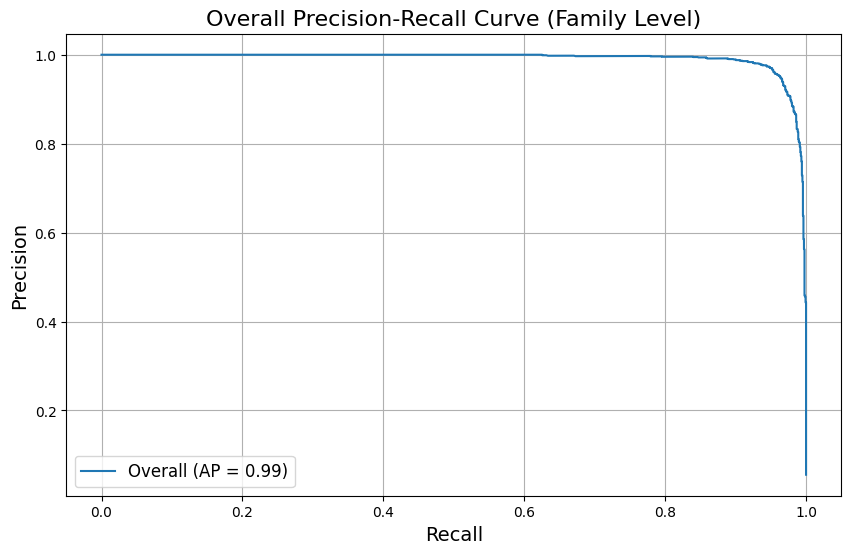

In [48]:
plot_overall_precision_recall_curve(
    model=CV_MODEL,
    test_ds=test_ds,
    output_layer="family"  # Change to "family" or "genus" as needed
)

In [49]:
import numpy as np
import pandas as pd

def analyze_class_distribution(test_ds, class_labels, output_layer="species"):
    """
    Analyze the class distribution for the specified output layer.

    Parameters:
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        class_labels (list): List of class names for the specified output layer.
        output_layer (str): Specifies which output layer to evaluate ("family", "genus", or "species").

    Returns:
        pd.DataFrame: A DataFrame showing the class distribution.
    """
    true_labels = []

    # Collect true labels
    for batch in test_ds:
        labels = batch[1]
        true_labels.extend(labels[output_layer].numpy())

    # Count occurrences of each class
    true_labels = np.argmax(true_labels, axis=1)
    class_counts = np.bincount(true_labels, minlength=len(class_labels))

    # Create DataFrame
    distribution_df = pd.DataFrame({
        "Class": class_labels,
        "Samples": class_counts
    })

    # Sort by sample count
    distribution_df = distribution_df.sort_values(by="Samples", ascending=True).reset_index(drop=True)
    return distribution_df

In [50]:
species_distribution = analyze_class_distribution(test_ds, species_labels, output_layer="species")
print(species_distribution)

                            Class  Samples
0             Limnichthys nitidus        8
1                 Eques punctatus        8
2             Pleurosicya labiata        8
3          Helcogramma fuscopinna        9
4           Scorpaenodes kelloggi        9
5           Centropyge flavissima        9
6                Enchelyurus ater        9
7                Fowleria vaiulae       10
8    Enneapterygius ventermaculus       10
9            Caracanthus unipinna       10
10         Enneapterygius pyramis       10
11       Paragobiodon lacunicolus       10
12            Enneanectes matador       11
13               Ecsenius pulcher       11
14          Trimma macrophthalmus       12
15            Aioliops megastigma       12
16          Paragobiodon modestus       12
17        Acanthemblemaria aspera       13
18        Pomacentrus amboinensis       13
19          Sebastapistes fowleri       14
20             Eviota albolineata       14
21      Plesiops coeruleolineatus       14
22         

In [51]:
def evaluate_class_performance_vs_distribution(model, test_ds, class_labels, output_layer="species"):
    """
    Evaluate class-level performance metrics and compare them to class distribution.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        class_labels (list): List of class names for the specified output layer.
        output_layer (str): Specifies which output layer to evaluate ("family", "genus", or "species").

    Returns:
        pd.DataFrame: A DataFrame with performance metrics and sample counts for each class.
    """
    from sklearn.metrics import precision_recall_fscore_support

    # Collect true labels and predictions
    true_labels = []
    pred_labels = []

    for batch in test_ds:
        images, labels = batch
        true_labels.extend(labels[output_layer].numpy())
        preds = model.predict(images, verbose=0)

        if output_layer == "family":
            pred_labels.extend(np.argmax(preds[0], axis=1))
        elif output_layer == "genus":
            pred_labels.extend(np.argmax(preds[1], axis=1))
        elif output_layer == "species":
            pred_labels.extend(np.argmax(preds[2], axis=1))

    # True and predicted labels as indices
    true_labels = np.argmax(np.array(true_labels), axis=1)

    # Compute metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, pred_labels, labels=range(len(class_labels)), zero_division=0
    )

    # Create DataFrame
    performance_df = pd.DataFrame({
        "Class": class_labels,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Support (Samples)": support
    })

    # Sort by support (sample count)
    performance_df = performance_df.sort_values(by="Support (Samples)", ascending=True).reset_index(drop=True)
    return performance_df

In [52]:
species_performance = evaluate_class_performance_vs_distribution(
    model=CV_MODEL,
    test_ds=test_ds,
    class_labels=species_labels,
    output_layer="species"
)
print(species_performance)

                            Class  Precision    Recall  F1-Score  \
0             Limnichthys nitidus   1.000000  0.875000  0.933333   
1                 Eques punctatus   1.000000  0.875000  0.933333   
2             Pleurosicya labiata   0.750000  0.750000  0.750000   
3          Helcogramma fuscopinna   0.875000  0.777778  0.823529   
4           Scorpaenodes kelloggi   0.875000  0.777778  0.823529   
5           Centropyge flavissima   0.900000  1.000000  0.947368   
6                Enchelyurus ater   1.000000  0.666667  0.800000   
7                Fowleria vaiulae   1.000000  0.600000  0.750000   
8    Enneapterygius ventermaculus   0.909091  1.000000  0.952381   
9            Caracanthus unipinna   1.000000  1.000000  1.000000   
10         Enneapterygius pyramis   1.000000  1.000000  1.000000   
11       Paragobiodon lacunicolus   1.000000  0.700000  0.823529   
12            Enneanectes matador   0.687500  1.000000  0.814815   
13               Ecsenius pulcher   0.777778  0.

In [53]:
def plot_class_imbalance_effects(performance_df):
    """
    Plot the relationship between class sample count and performance metrics.

    Parameters:
        performance_df (pd.DataFrame): DataFrame containing class performance metrics and sample counts.
    """
    plt.figure(figsize=(10, 6))

    # Scatter plot for Precision
    plt.scatter(performance_df["Support (Samples)"], performance_df["Precision"], label="Precision", alpha=0.7)
    
    # Scatter plot for Recall
    plt.scatter(performance_df["Support (Samples)"], performance_df["Recall"], label="Recall", alpha=0.7)
    
    # Scatter plot for F1-Score
    plt.scatter(performance_df["Support (Samples)"], performance_df["F1-Score"], label="F1-Score", alpha=0.7)
    
    plt.xscale("log")
    plt.xlabel("Support (Samples) [Log Scale]", fontsize=12)
    plt.ylabel("Performance Metric", fontsize=12)
    plt.title("Class Imbalance Effects on Model Performance", fontsize=14)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
plot_class_imbalance_effects(species_performance)

In [54]:
import pandas as pd

def hierarchical_consistency_analysis(model, test_ds, family_genus_map, genus_species_map, family_labels, genus_labels, species_labels):
    """
    Analyze the hierarchical consistency of the model's predictions.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model with three outputs.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels) batches.
        family_genus_map (dict): Mapping of families to valid genera (family → list of genera).
        genus_species_map (dict): Mapping of genera to valid species (genus → list of species).
        family_labels, genus_labels, species_labels (list): Class labels for Family, Genus, and Species.

    Returns:
        dict: A dictionary containing consistency metrics and DataFrame with detailed analysis.
    """
    # Initialize counters
    total_samples = 0
    fully_consistent = 0
    family_genus_inconsistent = 0
    genus_species_inconsistent = 0

    # Data for analysis
    analysis_data = []

    for batch in test_ds:
        images, labels = batch
        
        # Extract true labels
        true_family = tf.argmax(labels['family'], axis=1).numpy()
        true_genus = tf.argmax(labels['genus'], axis=1).numpy()
        true_species = tf.argmax(labels['species'], axis=1).numpy()

        # Predict
        preds = model.predict(images, verbose=0)
        pred_family = tf.argmax(preds[0], axis=1).numpy()
        pred_genus = tf.argmax(preds[1], axis=1).numpy()
        pred_species = tf.argmax(preds[2], axis=1).numpy()

        for i in range(len(true_family)):
            total_samples += 1

            # Map predicted indices to names
            pred_family_name = family_labels[pred_family[i]]
            pred_genus_name = genus_labels[pred_genus[i]]
            pred_species_name = species_labels[pred_species[i]]

            # Check Family → Genus consistency
            family_genus_consistent = pred_genus_name in family_genus_map.get(pred_family_name, [])

            # Check Genus → Species consistency
            genus_species_consistent = pred_species_name in genus_species_map.get(pred_genus_name, [])

            # Track hierarchical consistency
            if family_genus_consistent and genus_species_consistent:
                fully_consistent += 1
                consistency_status = "Fully Consistent"
            elif not family_genus_consistent and not genus_species_consistent:
                family_genus_inconsistent += 1
                genus_species_inconsistent += 1
                consistency_status = "Fully Inconsistent"
            elif not family_genus_consistent:
                family_genus_inconsistent += 1
                consistency_status = "Family → Genus Inconsistent"
            else:
                genus_species_inconsistent += 1
                consistency_status = "Genus → Species Inconsistent"

            # Collect analysis data
            analysis_data.append({
                "True Family": family_labels[true_family[i]],
                "Predicted Family": pred_family_name,
                "True Genus": genus_labels[true_genus[i]],
                "Predicted Genus": pred_genus_name,
                "True Species": species_labels[true_species[i]],
                "Predicted Species": pred_species_name,
                "Consistency Status": consistency_status
            })

    # Calculate metrics
    fully_consistent_rate = fully_consistent / total_samples
    family_genus_inconsistent_rate = family_genus_inconsistent / total_samples
    genus_species_inconsistent_rate = genus_species_inconsistent / total_samples

    metrics = {
        "fully_consistent_rate": fully_consistent_rate,
        "family_genus_inconsistent_rate": family_genus_inconsistent_rate,
        "genus_species_inconsistent_rate": genus_species_inconsistent_rate
    }

    # Create DataFrame for analysis
    analysis_df = pd.DataFrame(analysis_data)

    return {
        "metrics": metrics,
        "analysis_df": analysis_df
    }

In [55]:
hierarchical_results = hierarchical_consistency_analysis(
    model=CV_MODEL,
    test_ds=test_ds,
    family_genus_map=family_genus_map,
    genus_species_map=genus_species_map,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels
)

# Print metrics
print("Hierarchical Consistency Metrics:")
for metric, value in hierarchical_results["metrics"].items():
    print(f"{metric}: {value:.2%}")

# Display detailed analysis
print("Sample of Hierarchical Consistency Analysis:")
print(hierarchical_results["analysis_df"].head())

Hierarchical Consistency Metrics:
fully_consistent_rate: 94.24%
family_genus_inconsistent_rate: 3.25%
genus_species_inconsistent_rate: 3.84%
Sample of Hierarchical Consistency Analysis:
      True Family Predicted Family     True Genus Predicted Genus  \
0        Gobiidae         Gobiidae     Fusigobius      Fusigobius   
1     Cirrhitidae      Cirrhitidae   Neocirrhites    Neocirrhites   
2        Gobiidae         Gobiidae     Fusigobius      Fusigobius   
3  Chaetodontidae   Chaetodontidae      Chaetodon       Chaetodon   
4        Gobiidae         Gobiidae  Nemateleotris   Nemateleotris   

                True Species          Predicted Species Consistency Status  
0       Fusigobius neophytus       Fusigobius neophytus   Fully Consistent  
1       Neocirrhites armatus       Neocirrhites armatus   Fully Consistent  
2       Fusigobius neophytus       Fusigobius neophytus   Fully Consistent  
3  Chaetodon quadrimaculatus  Chaetodon quadrimaculatus   Fully Consistent  
4    Nemateleo

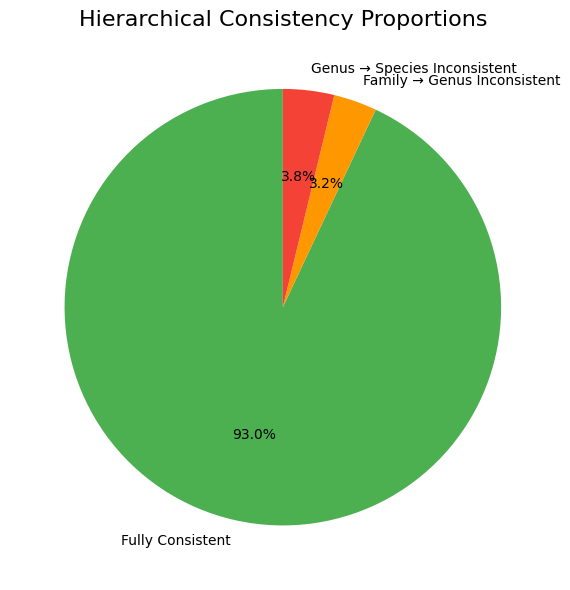

In [56]:
import matplotlib.pyplot as plt

def plot_hierarchical_consistency(metrics):
    """
    Create a visualization for the proportion of consistent and inconsistent predictions.

    Parameters:
        metrics (dict): A dictionary containing the consistency rates:
            - fully_consistent_rate
            - family_genus_inconsistent_rate
            - genus_species_inconsistent_rate
    """
    # Extract metrics
    fully_consistent = metrics["fully_consistent_rate"]
    family_genus_inconsistent = metrics["family_genus_inconsistent_rate"]
    genus_species_inconsistent = metrics["genus_species_inconsistent_rate"]

    # Calculate the total inconsistency rate
    total_inconsistent = family_genus_inconsistent + genus_species_inconsistent

    # Data for the plot
    labels = [
        "Fully Consistent",
        "Family → Genus Inconsistent",
        "Genus → Species Inconsistent"
    ]
    sizes = [
        fully_consistent * 100,  # Convert to percentage
        family_genus_inconsistent * 100,
        genus_species_inconsistent * 100
    ]
    colors = ["#4CAF50", "#FF9800", "#F44336"]  # Green, Orange, Red

    # Plot the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct="%.1f%%",
        startangle=90,
        colors=colors,
        textprops={"fontsize": 10}
    )
    plt.title("Hierarchical Consistency Proportions", fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_hierarchical_consistency(hierarchical_results["metrics"])


In [133]:
def analyze_inconsistent_classes(analysis_df):
    """
    Analyze which classes (Family, Genus, Species) contribute the most to hierarchical inconsistencies.

    Parameters:
        analysis_df (pd.DataFrame): Detailed analysis DataFrame from hierarchical consistency analysis.
            Must contain columns: "True Family", "True Genus", "True Species", "Consistency Status".

    Returns:
        dict: A dictionary containing DataFrames for inconsistencies grouped by Family, Genus, and Species.
    """
    # Group by True Family
    family_total = analysis_df.groupby("True Family")["Consistency Status"].count().reset_index()
    family_total = family_total.rename(columns={"Consistency Status": "Total"})
    
    family_inconsistencies = (
        analysis_df[analysis_df["Consistency Status"] != "Fully Consistent"]
        .groupby("True Family")["Consistency Status"]
        .count()
        .reset_index()
        .rename(columns={"Consistency Status": "Inconsistencies"})
    )
    family_inconsistencies = family_inconsistencies.merge(family_total, on="True Family", how="left")
    family_inconsistencies["Inconsistency Rate (%)"] = (family_inconsistencies["Inconsistencies"] / family_inconsistencies["Total"]) * 100

    # Group by True Genus
    genus_total = analysis_df.groupby("True Genus")["Consistency Status"].count().reset_index()
    genus_total = genus_total.rename(columns={"Consistency Status": "Total"})
    
    genus_inconsistencies = (
        analysis_df[analysis_df["Consistency Status"] != "Fully Consistent"]
        .groupby("True Genus")["Consistency Status"]
        .count()
        .reset_index()
        .rename(columns={"Consistency Status": "Inconsistencies"})
    )
    genus_inconsistencies = genus_inconsistencies.merge(genus_total, on="True Genus", how="left")
    genus_inconsistencies["Inconsistency Rate (%)"] = (genus_inconsistencies["Inconsistencies"] / genus_inconsistencies["Total"]) * 100

    # Group by True Species
    species_total = analysis_df.groupby("True Species")["Consistency Status"].count().reset_index()
    species_total = species_total.rename(columns={"Consistency Status": "Total"})
    
    species_inconsistencies = (
        analysis_df[analysis_df["Consistency Status"] != "Fully Consistent"]
        .groupby("True Species")["Consistency Status"]
        .count()
        .reset_index()
        .rename(columns={"Consistency Status": "Inconsistencies"})
    )
    species_inconsistencies = species_inconsistencies.merge(species_total, on="True Species", how="left")
    species_inconsistencies["Inconsistency Rate (%)"] = (species_inconsistencies["Inconsistencies"] / species_inconsistencies["Total"]) * 100

    # Sort by inconsistency rates
    family_inconsistencies = family_inconsistencies.sort_values(by="Inconsistency Rate (%)", ascending=False)
    genus_inconsistencies = genus_inconsistencies.sort_values(by="Inconsistency Rate (%)", ascending=False)
    species_inconsistencies = species_inconsistencies.sort_values(by="Inconsistency Rate (%)", ascending=False)

    return {
        "family": family_inconsistencies,
        "genus": genus_inconsistencies,
        "species": species_inconsistencies
    }

In [134]:
# Get inconsistent class analysis
inconsistent_classes = analyze_inconsistent_classes(hierarchical_results["analysis_df"])

# Display the top 5 families with the most inconsistencies
print("Top 5 Families with Most Inconsistencies:")
print(inconsistent_classes["family"].head())

# Display the top 5 genera with the most inconsistencies
print("\nTop 5 Genera with Most Inconsistencies:")
print(inconsistent_classes["genus"].head())

# Display the top 5 species with the most inconsistencies
print("\nTop 5 Species with Most Inconsistencies:")
print(inconsistent_classes["species"].head())

Top 5 Families with Most Inconsistencies:
     True Family  Inconsistencies  Total  Inconsistency Rate (%)
4     Creediidae                3      8               37.500000
2   Chaenopsidae                4     13               30.769231
1     Blenniidae                9     51               17.647059
7    Plesiopidae                2     14               14.285714
11    Sciaenidae                1      8               12.500000

Top 5 Genera with Most Inconsistencies:
          True Genus  Inconsistencies  Total  Inconsistency Rate (%)
21       Limnichthys                3      8               37.500000
33            Trimma                4     12               33.333333
9        Enchelyurus                3      9               33.333333
0   Acanthemblemaria                4     13               30.769231
14          Fowleria                3     10               30.000000

Top 5 Species with Most Inconsistencies:
               True Species  Inconsistencies  Total  Inconsistency Rate

In [136]:
import pandas as pd
import plotly.graph_objects as go

def plot_enhanced_hierarchical_misclassification_flow(analysis_df):
    """
    Plot an enhanced Sankey diagram showing the flow of hierarchical misclassifications.

    Parameters:
        analysis_df (pd.DataFrame): DataFrame from hierarchical consistency analysis containing:
            - 'True Family', 'Predicted Family'
            - 'True Genus', 'Predicted Genus'
            - 'True Species', 'Predicted Species'
    """
    # Define the stages of the hierarchy
    stages = ['True Family', 'Predicted Family', 'Predicted Genus', 'Predicted Species']

    # Combine all stages into a single list of unique labels
    labels = pd.concat([analysis_df[stage] for stage in stages]).unique().tolist()

    # Sort labels for better readability
    labels = sorted(labels)

    # Create mappings from labels to indices for the Sankey diagram
    label_to_index = {label: i for i, label in enumerate(labels)}

    # Initialize source, target, and value lists
    source = []
    target = []
    value = []
    hover_text = []

    # Populate the Sankey diagram data by grouping counts between stages
    for i in range(len(stages) - 1):
        stage_source = stages[i]
        stage_target = stages[i + 1]
        counts = (
            analysis_df.groupby([stage_source, stage_target])
            .size()
            .reset_index(name='count')
        )
        for _, row in counts.iterrows():
            source.append(label_to_index[row[stage_source]])
            target.append(label_to_index[row[stage_target]])
            value.append(row['count'])
            hover_text.append(f"{row[stage_source]} → {row[stage_target]}: {row['count']} samples")

    # Assign colors to nodes based on hierarchy
    node_colors = []
    for label in labels:
        if label in analysis_df['True Family'].values:
            node_colors.append('#4CAF50')  # Green for Family
        elif label in analysis_df['True Genus'].values:
            node_colors.append('#FFC107')  # Yellow for Genus
        elif label in analysis_df['True Species'].values:
            node_colors.append('#F44336')  # Red for Species
        else:
            node_colors.append('#9E9E9E')  # Gray for unknown

    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_text
        )
    ))

    # Add a title and adjust layout
    fig.update_layout(
        title_text="Enhanced Hierarchical Misclassification Flow",
        font_size=10,
        height=1000,  # Increase height for readability
        width=1200,   # Increase width for better spacing
    )
    fig.show()

# Example Usage
# Assuming hierarchical_results["analysis_df"] is available
plot_enhanced_hierarchical_misclassification_flow(hierarchical_results["analysis_df"])

In [65]:
import tensorflow as tf
import numpy as np

def extract_features(model, layer_name, test_ds):
    """
    Extract features from a specified layer of a model for the given dataset.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model.
        layer_name (str): Name of the layer to extract features from.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels).

    Returns:
        np.array: Extracted features.
        np.array: True labels corresponding to the features.
    """
    # Get the specified layer's output
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )

    features = []
    labels = []

    for batch in test_ds:
        images, label_batch = batch
        # Extract features
        batch_features = feature_extractor(images)
        features.append(batch_features.numpy())
        labels.append(label_batch['species'].numpy())  # Collect true species labels

    # Concatenate all features and labels
    features = np.concatenate(features)
    labels = np.argmax(np.concatenate(labels), axis=1)  # Convert one-hot to class indices
    return features, labels

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def reduce_and_plot(features, labels, class_names, method="pca"):
    """
    Reduce dimensions of features and plot a 2D scatter plot with labels.

    Parameters:
        features (np.array): Extracted features.
        labels (np.array): True labels corresponding to features.
        class_names (list): List of species class names.
        method (str): Dimensionality reduction method ("pca" or "tsne").
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    reduced_features = reducer.fit_transform(features)

    # Plot the reduced features
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap="tab20", alpha=0.7
    )
    plt.colorbar(scatter, ticks=range(len(class_names)), label="Species Classes")
    plt.clim(-0.5, len(class_names) - 0.5)
    plt.title(f"2D Feature Space ({method.upper()})", fontsize=16)
    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.show()
    
# Specify the layer from which to extract features
layer_name = "dense_1"  # Replace with the actual layer name in your model

# Extract features and true labels
features, labels = extract_features(CV_MODEL, layer_name, test_ds)

# Reduce dimensions and plot
reduce_and_plot(features, labels, species_labels, method="tsne")  # Use "pca" or "tsne"

In [89]:
# Extract features and true labels
features, labels = extract_features(CV_MODEL, 'shared_layer', test_ds)

# Reduce dimensions and plot
reduce_and_plot(features, labels, species_labels, method="tsne")  # Use "pca" or "tsne"

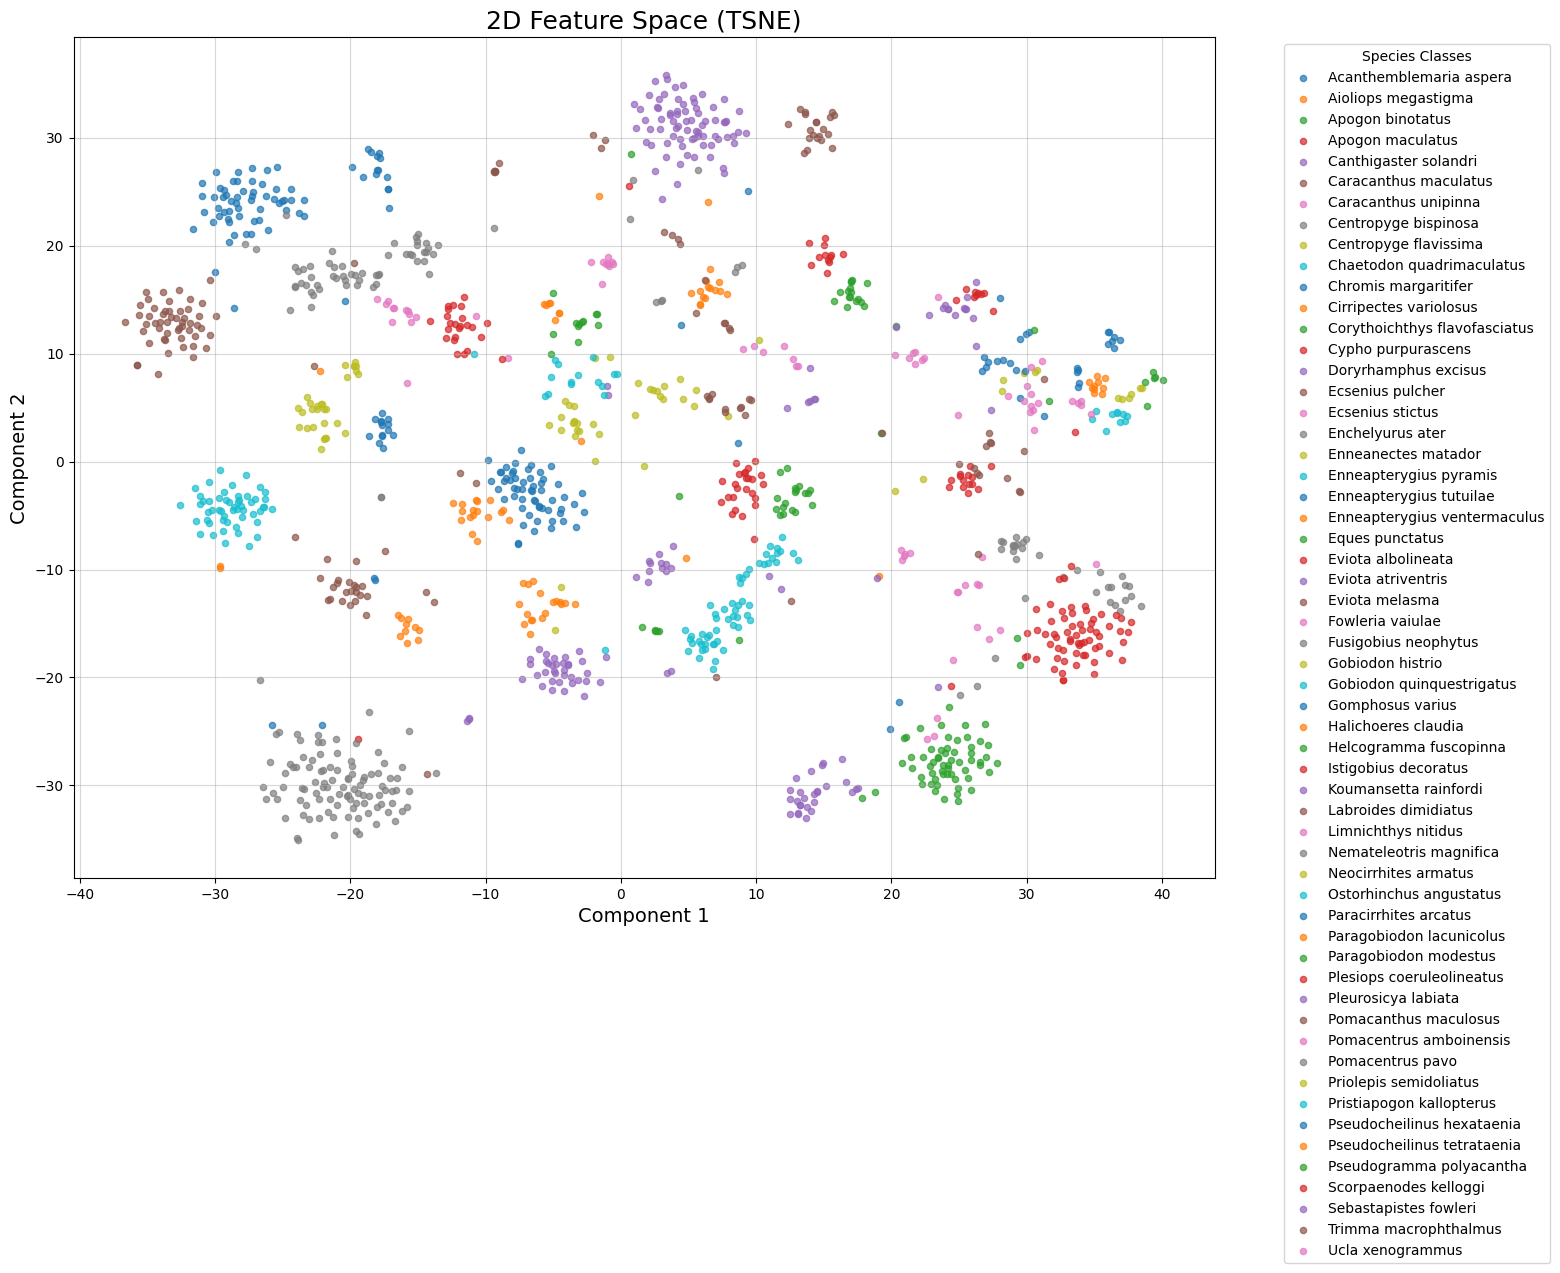

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reduce_and_plot_with_labels(features, labels, class_names, method="tsne"):
    """
    Reduce dimensions of features and plot a 2D scatter plot with labels.

    Parameters:
        features (np.array): Extracted features.
        labels (np.array): True labels corresponding to features.
        class_names (list): List of species class names.
        method (str): Dimensionality reduction method ("pca" or "tsne").
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    reduced_features = reducer.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(16, 12))
    unique_labels = np.unique(labels)
    scatter_points = []

    for label in unique_labels:
        idx = labels == label
        scatter = plt.scatter(
            reduced_features[idx, 0],
            reduced_features[idx, 1],
            label=class_names[label],
            s=20,
            alpha=0.7
        )
        scatter_points.append(scatter)

    # Improve plot aesthetics
    plt.legend(
        scatterpoints=1,
        loc='upper right',
        bbox_to_anchor=(1.3, 1.0),
        title="Species Classes",
        fontsize=10,
    )
    plt.title(f"2D Feature Space ({method.upper()})", fontsize=18)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()
    
# Example Usage
reduce_and_plot_with_labels(
    features=features,
    labels=labels,
    class_names=species_labels,
    method="tsne"  # Or "pca"
)

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def reduce_and_plot_with_unique_colors(features, labels, class_names, method="tsne"):
    """
    Reduce dimensions of features and plot a 2D scatter plot with labels.

    Parameters:
        features (np.array): Extracted features.
        labels (np.array): True labels corresponding to features.
        class_names (list): List of species class names.
        method (str): Dimensionality reduction method ("pca" or "tsne").
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    reduced_features = reducer.fit_transform(features)

    # Generate a unique color for each species
    num_classes = len(class_names)
    cmap = plt.cm.get_cmap("tab20", num_classes)  # Use "tab20" or "viridis"
    colors = cmap(np.arange(num_classes))

    # Create a scatter plot
    plt.figure(figsize=(16, 12))
    unique_labels = np.unique(labels)

    for label in unique_labels:
        idx = labels == label
        plt.scatter(
            reduced_features[idx, 0],
            reduced_features[idx, 1],
            label=class_names[label],
            color=colors[label],
            s=20,
            alpha=0.7
        )

    # Improve plot aesthetics
    plt.legend(
        scatterpoints=1,
        loc='upper right',
        bbox_to_anchor=(1.3, 1.0),
        title="Species Classes",
        fontsize=10,
    )
    plt.title(f"2D Feature Space ({method.upper()})", fontsize=18)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [67]:
# Example Usage
reduce_and_plot_with_unique_colors(
    features=features,
    labels=labels,
    class_names=species_labels,
    method="tsne"  # Or "pca"
)

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_12994/2933170190.py:28: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Overall Silhouette Score: 0.1840
                     Species      mean       std
0    Acanthemblemaria aspera  0.056739  0.049776
1        Aioliops megastigma  0.196990  0.114764
2           Apogon binotatus  0.137905  0.077119
3           Apogon maculatus  0.139314  0.059227
4      Canthigaster solandri  0.169852  0.121860
5      Caracanthus maculatus  0.282291  0.086361
6       Caracanthus unipinna  0.243884  0.090477
7       Centropyge bispinosa  0.336596  0.096480
8      Centropyge flavissima  0.188873  0.067427
9  Chaetodon quadrimaculatus  0.434848  0.107491


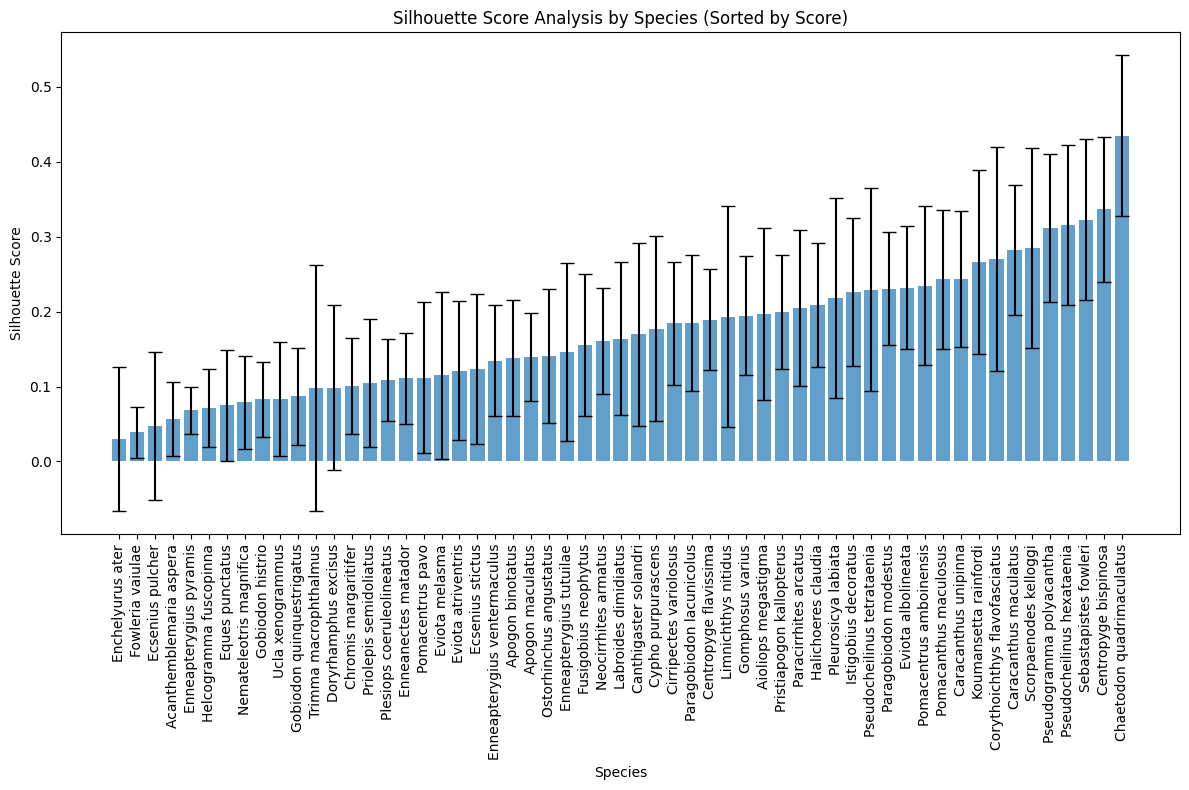

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Perform Clustering
def apply_clustering(features, n_clusters=10):
    """
    Apply K-Means clustering on the features.
    
    Parameters:
        features (np.ndarray): 2D array of features (e.g., t-SNE or PCA reduced features).
        n_clusters (int): Number of clusters for K-Means.
    
    Returns:
        np.ndarray: Cluster labels assigned to each sample.
        KMeans: Trained K-Means model.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans

# Step 2: Calculate Silhouette Score for Each Sample
def calculate_silhouette(features, cluster_labels):
    """
    Calculate silhouette scores for each sample and overall silhouette score.
    
    Parameters:
        features (np.ndarray): 2D array of features.
        cluster_labels (np.ndarray): Cluster labels assigned to each sample.
    
    Returns:
        dict: Overall silhouette score and silhouette scores for each sample.
    """
    overall_silhouette = silhouette_score(features, cluster_labels)
    sample_silhouettes = silhouette_samples(features, cluster_labels)
    return {
        "overall_silhouette": overall_silhouette,
        "sample_silhouettes": sample_silhouettes
    }

# Step 3: Silhouette Score Analysis for Each Class
def silhouette_by_species(labels, sample_silhouettes, species_labels):
    """
    Analyze silhouette scores by species.
    
    Parameters:
        labels (np.ndarray): Ground truth labels (species).
        sample_silhouettes (np.ndarray): Silhouette scores for each sample.
        species_labels (list): List of species class names.
    
    Returns:
        pd.DataFrame: Silhouette scores for each species.
    """
    df = pd.DataFrame({"Species": labels, "Silhouette Score": sample_silhouettes})
    silhouette_by_class = df.groupby("Species")["Silhouette Score"].agg(["mean", "std"]).reset_index()
    silhouette_by_class["Species"] = silhouette_by_class["Species"].apply(lambda x: species_labels[x])
    return silhouette_by_class

# Step 4: Visualize Silhouette Scores with Sorting
def plot_silhouette_analysis_sorted(silhouette_df):
    """
    Plot silhouette analysis results sorted by mean silhouette score.

    Parameters:
        silhouette_df (pd.DataFrame): DataFrame containing species and silhouette scores.
    """
    # Sort the DataFrame by mean silhouette score in ascending order
    silhouette_df = silhouette_df.sort_values(by="mean", ascending=True)

    plt.figure(figsize=(12, 8))
    plt.bar(silhouette_df["Species"], silhouette_df["mean"], yerr=silhouette_df["std"], capsize=5, alpha=0.7)
    plt.xticks(rotation=90)
    plt.ylabel("Silhouette Score")
    plt.xlabel("Species")
    plt.title("Silhouette Score Analysis by Species (Sorted by Score)")
    plt.tight_layout()
    plt.show()
# Combine Steps to Analyze and Plot
# Step 5: Apply clustering and compute silhouette scores
n_clusters = len(species_labels)  # Assuming one cluster per species
cluster_labels, kmeans_model = apply_clustering(features, n_clusters=n_clusters)

silhouette_results = calculate_silhouette(features, cluster_labels)
silhouette_df = silhouette_by_species(labels, silhouette_results["sample_silhouettes"], species_labels)

# Step 6: Display Results
print(f"Overall Silhouette Score: {silhouette_results['overall_silhouette']:.4f}")
print(silhouette_df.head(10))

# Step 7: Plot Silhouette Analysis
plot_silhouette_analysis_sorted(silhouette_df)

In [74]:
from scipy.stats import spearmanr, pearsonr

def merge_silhouette_with_metrics(silhouette_df, metrics_df):
    """
    Merge silhouette scores with performance metrics for correlation analysis.

    Parameters:
        silhouette_df (pd.DataFrame): DataFrame with mean silhouette scores.
        metrics_df (pd.DataFrame): DataFrame with support, precision, recall, F1, etc.

    Returns:
        pd.DataFrame: Combined DataFrame with silhouette scores and metrics.
    """
    # Merge DataFrames on the species name
    combined_df = pd.merge(
        silhouette_df,
        metrics_df,
        how="inner",
        left_on="Species",  # Assuming 'Species' column exists in silhouette_df
        right_on="Class"    # Assuming 'Class' column exists in metrics_df
    )
    return combined_df

# Example: Assuming metrics_df has support, precision, recall, etc.
combined_df = merge_silhouette_with_metrics(silhouette_df, pclass_metrics['species'])  # Replace `species_metrics_df`

# Display the combined data
combined_df.head()

Species      mean       std                    Class  \
0  Acanthemblemaria aspera  0.056739  0.049776  Acanthemblemaria aspera   
1      Aioliops megastigma  0.196990  0.114764      Aioliops megastigma   
2         Apogon binotatus  0.137905  0.077119         Apogon binotatus   
3         Apogon maculatus  0.139314  0.059227         Apogon maculatus   
4    Canthigaster solandri  0.169852  0.121860    Canthigaster solandri   

   Precision  Recall  F1-Score  Support  Error Percentage  
0   0.928571     1.0  0.962963       13               0.0  
1   1.000000     1.0  1.000000       12               0.0  
2   1.000000     1.0  1.000000       19               0.0  
3   0.892857     1.0  0.943396       25               0.0  
4   0.986842     1.0  0.993377       75               0.0

In [75]:
def calculate_correlations(combined_df):
    """
    Calculate correlations between silhouette scores and performance metrics.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame with silhouette scores and metrics.

    Returns:
        pd.DataFrame: Correlation values for each metric.
    """
    correlations = {}
    metrics = ["Support", "Precision", "Recall", "F1-Score", "Accuracy"]  # Adjust based on actual metric names

    for metric in metrics:
        if metric in combined_df.columns:
            # Pearson correlation
            pearson_corr, _ = pearsonr(combined_df["mean"], combined_df[metric])
            # Spearman correlation
            spearman_corr, _ = spearmanr(combined_df["mean"], combined_df[metric])
            correlations[metric] = {"Pearson": pearson_corr, "Spearman": spearman_corr}

    return pd.DataFrame(correlations).transpose()

# Calculate correlations
correlations_df = calculate_correlations(combined_df)

# Display the correlation results
print(correlations_df)

            Pearson  Spearman
Support    0.179582  0.210378
Precision  0.089110  0.032800
Recall     0.295270  0.182671
F1-Score   0.283220  0.255127


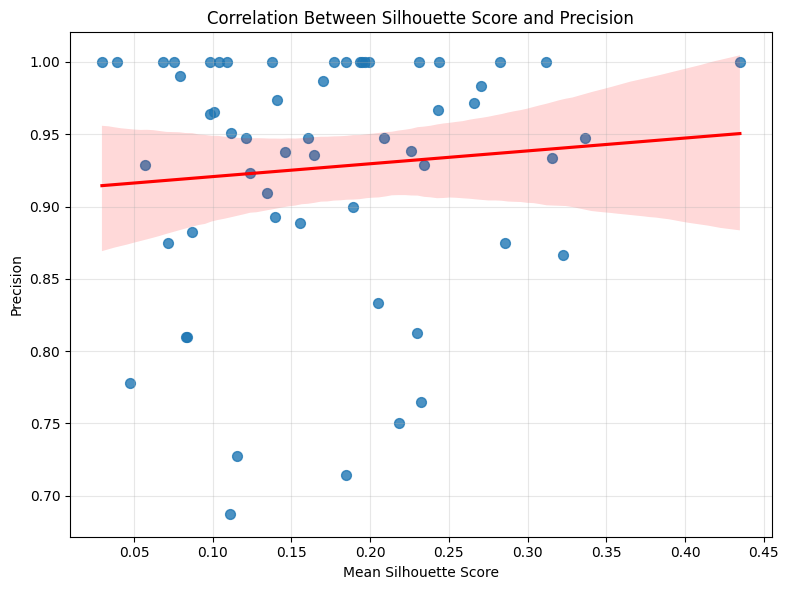

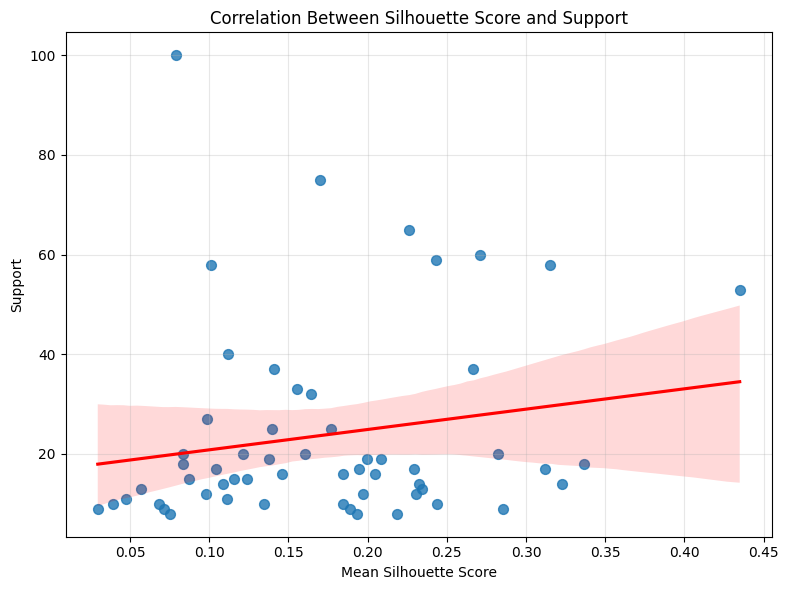

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_correlation(combined_df, metric):
    """
    Plot scatter plot and regression line for silhouette score vs. a specific metric.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame with silhouette scores and metrics.
        metric (str): The metric to analyze (e.g., "Precision", "F1-Score").
    """
    if metric not in combined_df.columns:
        print(f"Metric '{metric}' not found in DataFrame.")
        return
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x="mean", y=metric, data=combined_df, scatter_kws={"s": 50}, line_kws={"color": "red"})
    plt.title(f"Correlation Between Silhouette Score and {metric}")
    plt.xlabel("Mean Silhouette Score")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage: Visualize correlations for Precision and Recall
plot_metric_correlation(combined_df, "Precision")
plot_metric_correlation(combined_df, "Recall")
plot_metric_correlation(combined_df, "Support")

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def reduce_and_plot_by_level(features, labels, class_names, level_name="species", method="tsne"):
    """
    Reduce dimensions of features and plot a 2D scatter plot for the specified level (family, genus, or species).

    Parameters:
        features (np.array): Extracted features.
        labels (np.array): True labels corresponding to features.
        class_names (list): List of class names (family, genus, or species).
        level_name (str): Name of the prediction level ("family", "genus", or "species").
        method (str): Dimensionality reduction method ("pca" or "tsne").
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    reduced_features = reducer.fit_transform(features)

    # Generate a unique color for each class
    num_classes = len(class_names)
    cmap = plt.cm.get_cmap("tab20", num_classes)  # Use "tab20" or "viridis"
    colors = cmap(np.arange(num_classes))

    # Create a scatter plot
    plt.figure(figsize=(16, 12))
    unique_labels = np.unique(labels)

    for label in unique_labels:
        idx = labels == label
        plt.scatter(
            reduced_features[idx, 0],
            reduced_features[idx, 1],
            label=class_names[label],
            color=colors[label],
            s=20,
            alpha=0.7
        )

    # Improve plot aesthetics
    plt.legend(
        scatterpoints=1,
        loc='upper right',
        bbox_to_anchor=(1.3, 1.0),
        title=f"{level_name.capitalize()} Classes",
        fontsize=10,
    )
    plt.title(f"2D Feature Space ({method.upper()}) - {level_name.capitalize()}", fontsize=18)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [150]:
def extract_features_by_level(model, layer_name, test_ds, level="family"):
    """
    Extract features from a specified layer for the given dataset and prediction level.

    Parameters:
        model (tf.keras.Model): Trained TensorFlow model.
        layer_name (str): Name of the layer to extract features from.
        test_ds (tf.data.Dataset): Test dataset containing (images, labels).
        level (str): Level of labels to extract ("family", "genus", or "species").

    Returns:
        np.array: Extracted features.
        np.array: True labels corresponding to the features.
    """
    # Get the specified layer's output
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )

    features = []
    labels = []

    for batch in test_ds:
        images, label_batch = batch
        # Extract features
        batch_features = feature_extractor(images)
        features.append(batch_features.numpy())
        labels.append(label_batch[level].numpy())  # Extract family, genus, or species labels

    # Concatenate all features and labels
    features = np.concatenate(features)
    labels = np.argmax(np.concatenate(labels), axis=1)  # Convert one-hot to class indices
    return features, labels

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_3094/1494618043.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



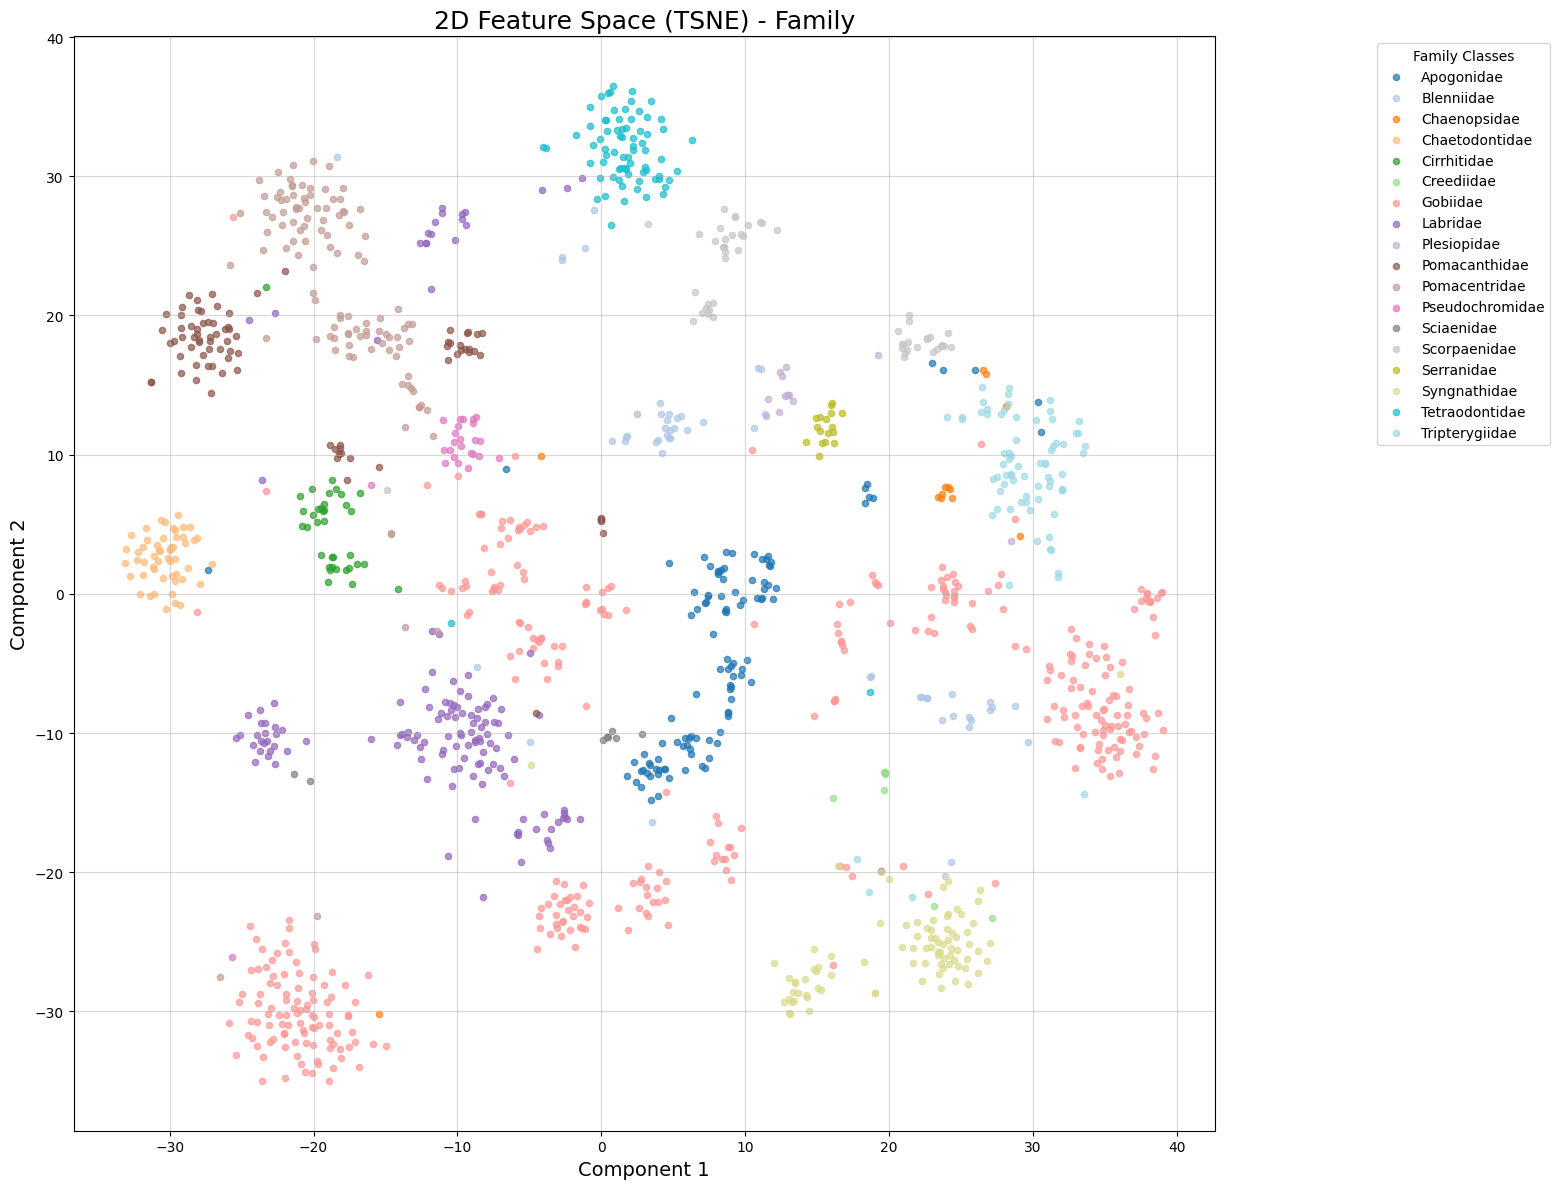

In [152]:
# Extract features and true labels
family_features, labels = extract_features_by_level(CV_MODEL, layer_name, test_ds, "family")

reduce_and_plot_by_level(
    features=family_features,  # Extracted features for family
    labels=labels,      # Family-level true labels
    class_names=family_labels,  # List of family class names
    level_name="family",       # Indicate family level
    method="tsne"              # Use "tsne" or "pca"
)

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_misclassification_data(analysis_df):
    """
    Prepare misclassification data for Family, Genus, and Species levels.

    Parameters:
        analysis_df (pd.DataFrame): DataFrame containing hierarchical predictions:
            - 'True Family', 'Predicted Family'
            - 'True Genus', 'Predicted Genus'
            - 'True Species', 'Predicted Species'

    Returns:
        pd.DataFrame: A DataFrame summarizing misclassification rates by level.
    """
    # Calculate total and misclassified counts for each level
    def calculate_error_percentage(true_col, pred_col, level_name):
        errors = (analysis_df[true_col] != analysis_df[pred_col])
        counts = analysis_df.groupby(true_col).size()
        error_counts = analysis_df[errors].groupby(true_col).size()
        error_percentage = (error_counts / counts * 100).fillna(0)

        return pd.DataFrame({
            "Class": error_percentage.index,
            "Error Percentage": error_percentage.values,
            "Level": level_name
        })

    family_errors = calculate_error_percentage("True Family", "Predicted Family", "Family")
    genus_errors = calculate_error_percentage("True Genus", "Predicted Genus", "Genus")
    species_errors = calculate_error_percentage("True Species", "Predicted Species", "Species")

    # Combine data for all levels
    combined_errors = pd.concat([family_errors, genus_errors, species_errors], ignore_index=True)
    return combined_errors

# Example usage:
misclassification_data = prepare_misclassification_data(hierarchical_results["analysis_df"])
print(misclassification_data.head())

            Class  Error Percentage   Level
0      Apogonidae          3.636364  Family
1      Blenniidae          7.843137  Family
2    Chaenopsidae         30.769231  Family
3  Chaetodontidae          0.000000  Family
4     Cirrhitidae          0.000000  Family


In [64]:
misclassification_data.sort_values('Error Percentage', ascending=False)

Class  Error Percentage    Level
88             Eviota melasma         46.666667  Species
89           Fowleria vaiulae         40.000000  Species
5                  Creediidae         37.500000   Family
52                Pleurosicya         37.500000    Genus
78           Ecsenius pulcher         36.363636  Species
..                        ...               ...      ...
48               Ostorhinchus          0.000000    Genus
37                 Fusigobius          0.000000    Genus
92  Gobiodon quinquestrigatus          0.000000  Species
69       Caracanthus unipinna          0.000000  Species
60              Sebastapistes          0.000000    Genus

[120 rows x 3 columns]

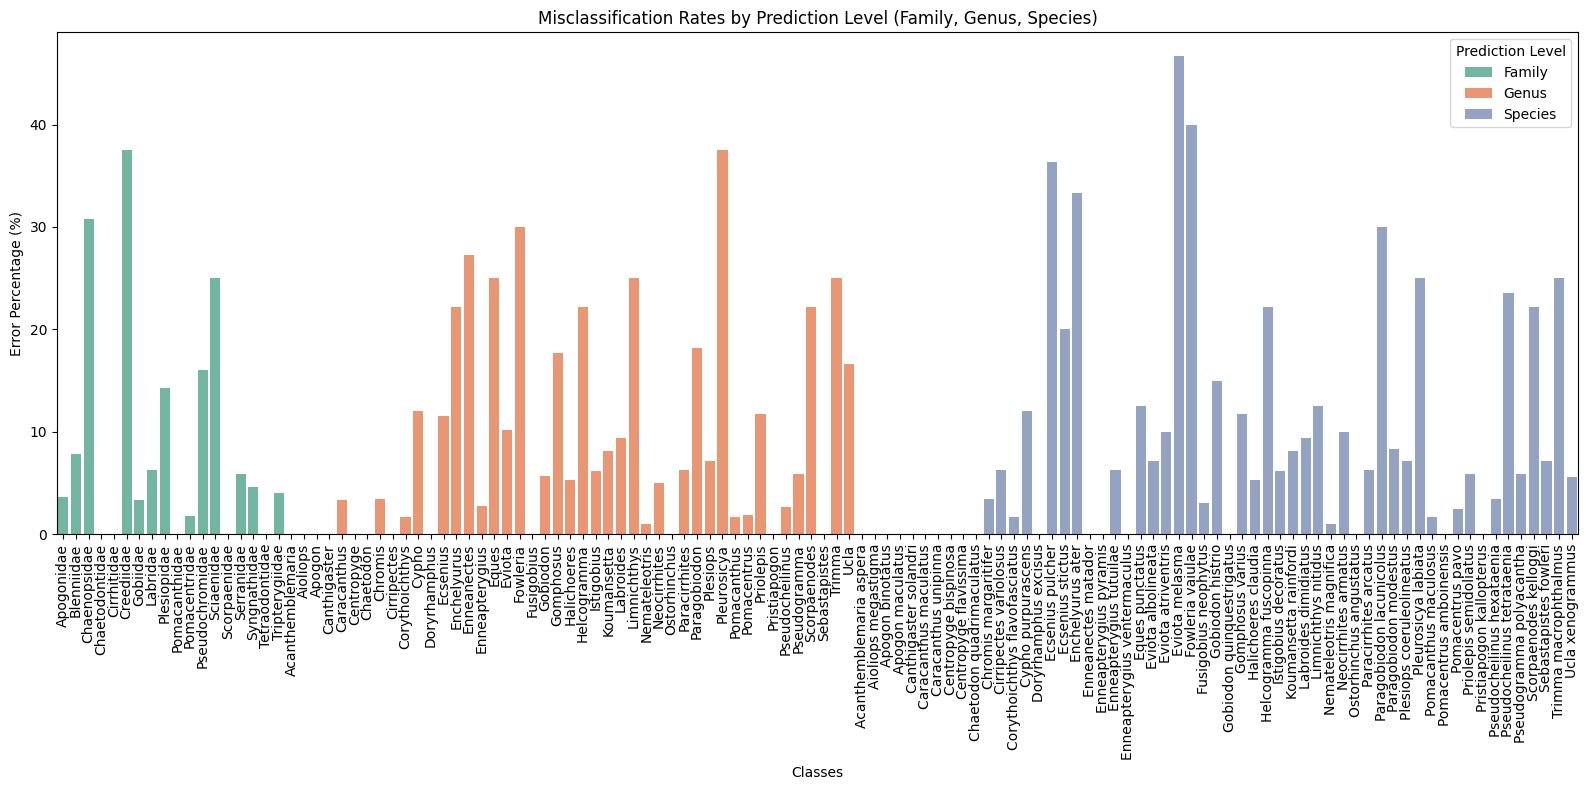

In [59]:
def plot_misclassification_bar(data):
    """
    Plot misclassification percentages as bar plots for Family, Genus, and Species levels.

    Parameters:
        data (pd.DataFrame): DataFrame summarizing misclassification rates by level.
    """
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=data,
        x="Class",
        y="Error Percentage",
        hue="Level",
        palette="Set2"
    )
    plt.xticks(rotation=90)
    plt.xlabel("Classes")
    plt.ylabel("Error Percentage (%)")
    plt.title("Misclassification Rates by Prediction Level (Family, Genus, Species)")
    plt.legend(title="Prediction Level")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_misclassification_bar(misclassification_data)

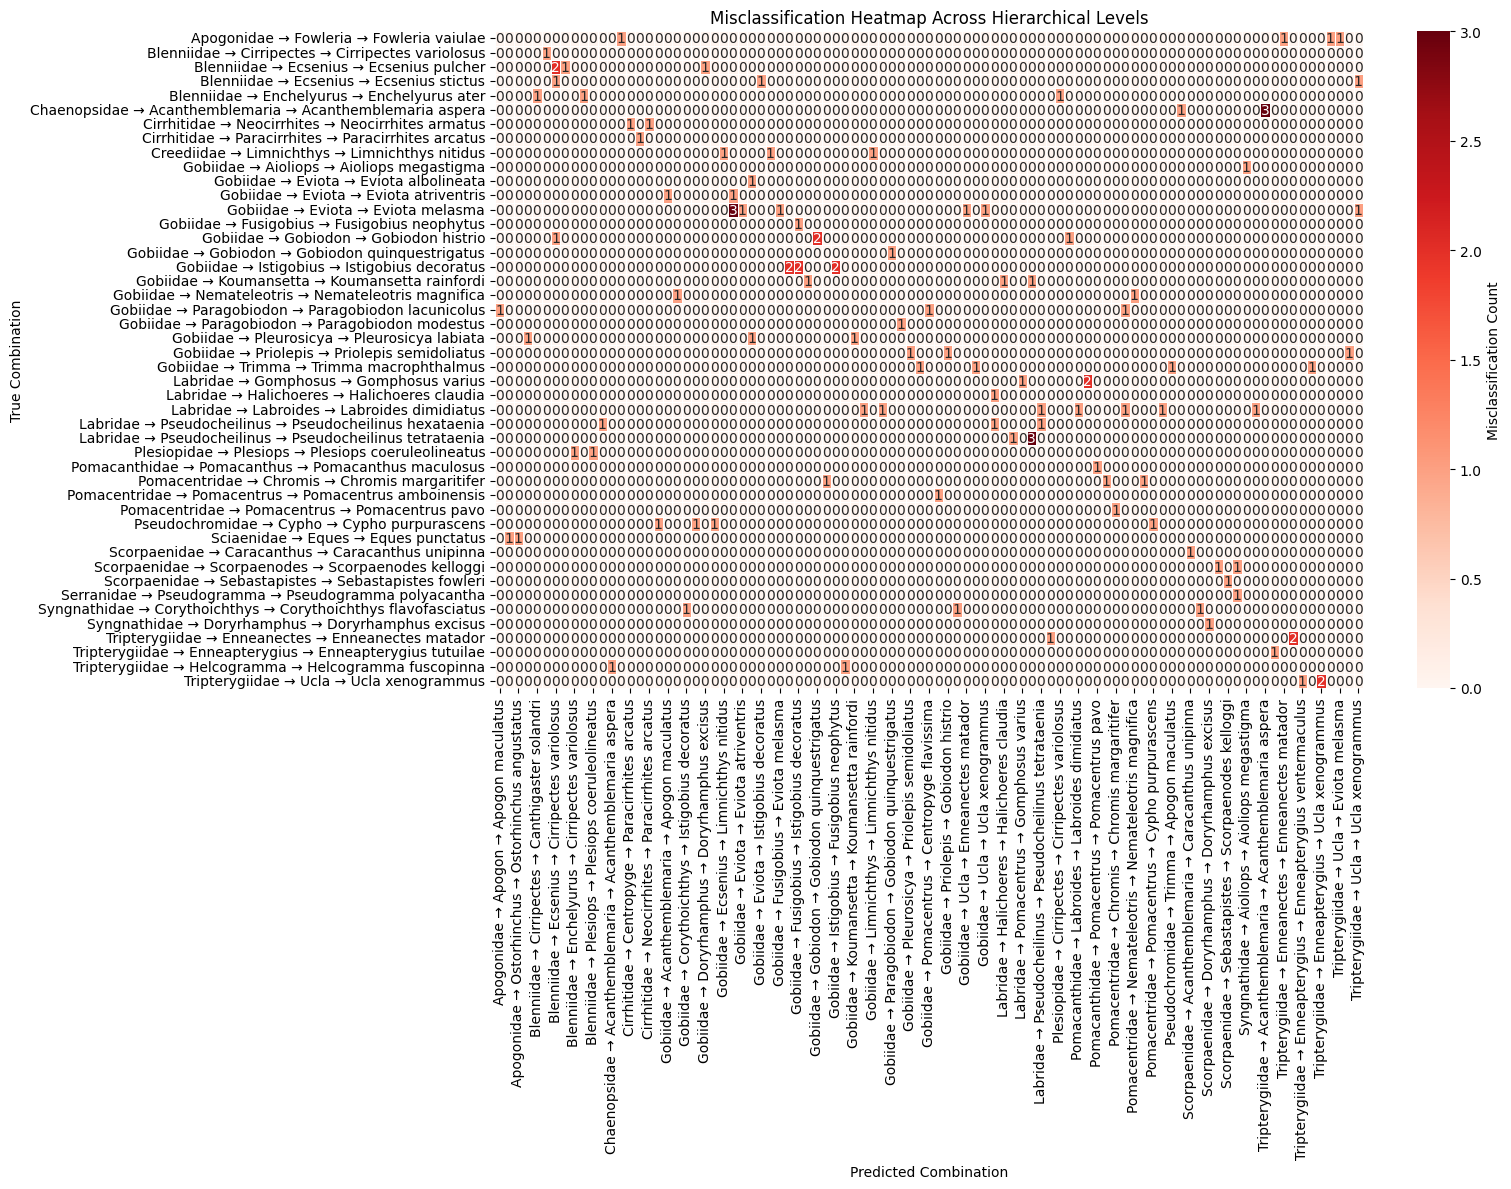

In [61]:
def plot_combined_misclassification_heatmap(analysis_df):
    """
    Create a heatmap showing combined misclassification rates across hierarchical levels.

    Parameters:
        analysis_df (pd.DataFrame): DataFrame containing hierarchical predictions.
    """
    # Calculate error percentages for combined relationships
    combined_errors = analysis_df.copy()
    combined_errors["True Combination"] = (
        combined_errors["True Family"] + " → " +
        combined_errors["True Genus"] + " → " +
        combined_errors["True Species"]
    )
    combined_errors["Predicted Combination"] = (
        combined_errors["Predicted Family"] + " → " +
        combined_errors["Predicted Genus"] + " → " +
        combined_errors["Predicted Species"]
    )

    # Aggregate misclassification counts
    error_counts = combined_errors[combined_errors["True Combination"] != combined_errors["Predicted Combination"]]
    heatmap_data = (
        error_counts.groupby(["True Combination", "Predicted Combination"])
        .size()
        .unstack(fill_value=0)
    )

    # Plot heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt="d",
        cmap="Reds",
        linewidths=0.5,
        cbar_kws={"label": "Misclassification Count"}
    )
    plt.title("Misclassification Heatmap Across Hierarchical Levels")
    plt.xlabel("Predicted Combination")
    plt.ylabel("True Combination")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_misclassification_heatmap(hierarchical_results["analysis_df"])

In [126]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def grad_cam(model, base_model, img_array, class_index, layer_name="conv5_block3_out"):
    """
    Generate Grad-CAM heatmap for a specific class index.

    Parameters:
        model (tf.keras.Model): The trained model.
        img_array (np.ndarray): Preprocessed input image array.
        class_index (int): The class index to compute Grad-CAM for.
        layer_name (str): Name of the convolutional layer to use for Grad-CAM.

    Returns:
        np.ndarray: The Grad-CAM heatmap.
    """
    # Create a model that maps the input to the last convolutional layer and the output
    grad_model = tf.keras.models.Model(
        [base_model.input], 
        [base_model.get_layer(layer_name).output,]
    )
    

    # Compute the gradient of the class score with respect to the feature maps
    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        predictions = model(img_array)
        loss = predictions[0][:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Weight the feature maps
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(guided_grads, axis=0)
    cam = np.zeros(conv_outputs.shape[:-1], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    # Normalize the heatmap
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)
    return cam

In [26]:
import keras

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    
    resnet = tf.keras.models.Model(
        inputs=model.get_layer('resnet50v2').inputs,
        outputs=[model.get_layer('resnet50v2').get_layer(last_conv_layer_name).output, model.get_layer('resnet50v2').output],
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = resnet(img_array)
        #preds = model(img_array)[0]
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [23]:
def preprocess_image(img_path, target_size=(384, 384)):
    """
    Preprocess an image for the model.

    Parameters:
        img_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image.

    Returns:
        np.ndarray: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

def overlay_grad_cam(img_path, heatmap, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on the original image.

    Parameters:
        img_path (str): Path to the image file.
        heatmap (np.ndarray): Grad-CAM heatmap.
        alpha (float): Transparency of the overlay.

    Returns:
        None
    """
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Resize heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))
    heatmap = tf.squeeze(heatmap).numpy()

    # Apply colormap to heatmap
    heatmap = plt.cm.jet(heatmap)[:, :, :3]  # Ignore alpha channel
    overlay = heatmap * 255 * alpha + img_array * (1 - alpha)
    overlay = np.uint8(overlay)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

In [27]:
img_path = test_df['image_path'].values[0]
img_array = preprocess_image(img_path)
class_index = 10  # Replace with the class index you want to analyze
layer_name = "conv5_block3_out"  # Confirm this name from the ResNet50v2 summary

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, CV_MODEL, layer_name)

2024-12-09 18:09:33.241679: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [12,2048]
	 [[{{node Pack}}]]


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [12,2048]
	 [[{{node Pack}}]] [Op:Pack] name: 

In [128]:
img_path = test_df['image_path'].values[0]  # Use an image path from your test DataFrame
class_index = 10  # Replace with the class index you want to analyze
layer_name = "conv5_block3_out"  # Confirm this name from the ResNet50v2 summary

# Preprocess the image
preprocessed_image = preprocess_image(img_path)

resnet = CV_MODEL.get_layer("resnet50v2")

# Generate Grad-CAM heatmap
heatmap = grad_cam(CV_MODEL, resnet, preprocessed_image, class_index, layer_name)

# Overlay the Grad-CAM heatmap on the original image
overlay_grad_cam(img_path, heatmap)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [125]:
import tensorflow.keras.config as config
#config.disable_traceback_filtering()

resnet = CV_MODEL.get_layer("resnet50v2")



grad_model = tf.keras.models.Model(
        [resnet.input], 
        [
            resnet.get_layer(layer_name).output,
            #CV_MODEL.get_layer("family").output, 
            CV_MODEL.output
        ]
    )

for batch in test_ds.take(1):
    image, label = batch
    predictions = grad_model(image)
    
predictions[0]

KeyError: 20425811008

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        """
        Initialize Grad-CAM for a model with a specific last convolutional layer
        
        Parameters:
        - model: Trained Keras model
        - last_conv_layer_name: Name of the last convolutional layer to visualize
        """
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name
        
        # Create gradient model
        self.grad_model = self.create_grad_model()
    
    def create_grad_model(self):
        """
        Create a model that outputs the last conv layer's output and the model's output
        """
        # Find the last convolutional layer
        last_conv_layer = self.model.get_layer('resnet50v2').get_layer(self.last_conv_layer_name)
        
        # Create a model with inputs and outputs
        grad_model = tf.keras.models.Model(
            [self.model.get_layer('resnet50v2').inputs], 
            [last_conv_layer.output, self.model.get_layer('resnet50v2').output]
        )
        
        return grad_model
    
    def compute_heatmap(self, img, class_index=None):
        """
        Compute Grad-CAM heatmap
        
        Parameters:
        - img: Input image tensor
        - class_index: Index of class to visualize (if None, uses the predicted class)
        
        Returns:
        - Heatmap of gradients
        """
        # Expand dimensions if needed
        if len(img.shape) == 3:
            img = tf.expand_dims(img, 0)
        
        # Compute gradients
        with tf.GradientTape() as tape:
            conv_outputs = self.grad_model(img)
            predictions = self.model(img)
            
            predictions = predictions[0] if isinstance(predictions, list) else predictions
            
            # If no specific class is provided, use the top predicted class
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            
            # Compute the loss for the specific class
            class_output = predictions[0][:, class_index]
        
        # Get the gradients of the class output with respect to the conv layer output
        grads = tape.gradient(class_output, conv_outputs)
        
        # Global Average Pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Multiply each gradient by its corresponding feature map
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(
            tf.multiply(pooled_grads, conv_outputs), 
            axis=-1
        )
        
        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    def overlay_heatmap(self, original_img, heatmap, alpha=0.4):
        """
        Overlay the heatmap on the original image
        
        Parameters:
        - original_img: Original image
        - heatmap: Computed heatmap
        - alpha: Transparency of the heatmap
        
        Returns:
        - Image with heatmap overlaid
        """
        # Resize heatmap to match image dimensions
        heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        
        # Apply color map
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        # Convert image to uint8 if needed
        if original_img.dtype == np.float32 or original_img.dtype == np.float64:
            original_img = (original_img * 255).astype(np.uint8)
        elif original_img.dtype != np.uint8:
            original_img = original_img.astype(np.uint8)
        
        # Overlay heatmap
        superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
        return superimposed_img
    
    def plot_grad_cam(self, img, class_index=None, alpha=0.4):
        """
        Visualize Grad-CAM
        
        Parameters:
        - img: Input image
        - class_index: Class to visualize (optional)
        - alpha: Heatmap transparency
        """
        # Compute heatmap
        heatmap = self.compute_heatmap(img, class_index)
        
        # Overlay heatmap
        superimposed_img = self.overlay_heatmap(
            original_img=img[0] if len(img.shape) == 4 else img, 
            heatmap=heatmap, 
            alpha=alpha
        )
        
        # Plot results
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(img[0] if len(img.shape) == 4 else img)
        plt.axis('off')
        
        plt.subplot(132)
        plt.title('Grad-CAM Heatmap')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')
        
        plt.subplot(133)
        plt.title('Grad-CAM Overlay')
        plt.imshow(superimposed_img)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage
def prepare_grad_cam(model, test_data, layer_name):
    """
    Helper function to prepare Grad-CAM visualization
    
    Parameters:
    - model: Trained Keras model
    - test_data: Test dataset or image
    - layer_name: Name of the last convolutional layer
    
    Returns:
    - Grad-CAM instance
    """
    # Create Grad-CAM instance
    grad_cam = GradCAM(model, layer_name)
    
    return grad_cam

In [32]:
grad_cam = GradCAM(CV_MODEL, "conv5_block3_out")

In [ ]:
# For a single image from your test dataset
for batch in test_ds.take(1):
    image, label = batch
    grad_cam.plot_grad_cam(image)

# Old

In [ ]:
for key in second_level_metrics.keys():
    print(f"Correlation for {key.upper()} level:")
    print(second_level_metrics[key][["Support","F1-Score"]].corr())
    print("_____________________________________________________________")

Correlation for FAMILY level:
           Support  F1-Score
Support   1.000000  0.389442
F1-Score  0.389442  1.000000
_____________________________________________________________
Correlation for GENUS level:
           Support  F1-Score
Support   1.000000  0.527671
F1-Score  0.527671  1.000000
_____________________________________________________________
Correlation for SPECIES level:
           Support  F1-Score
Support   1.000000  0.380372
F1-Score  0.380372  1.000000
_____________________________________________________________


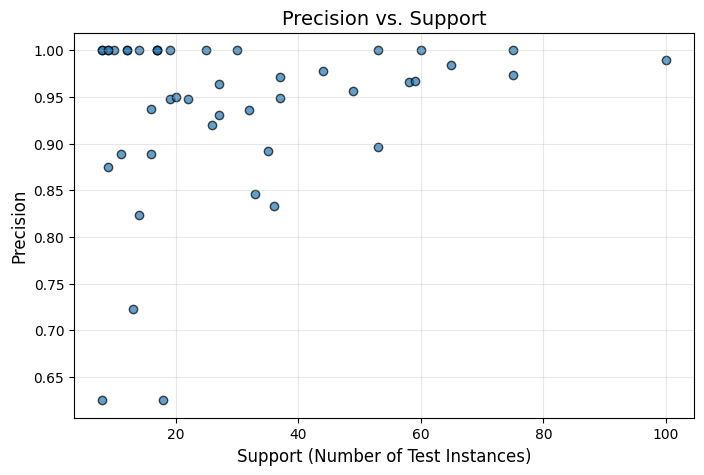

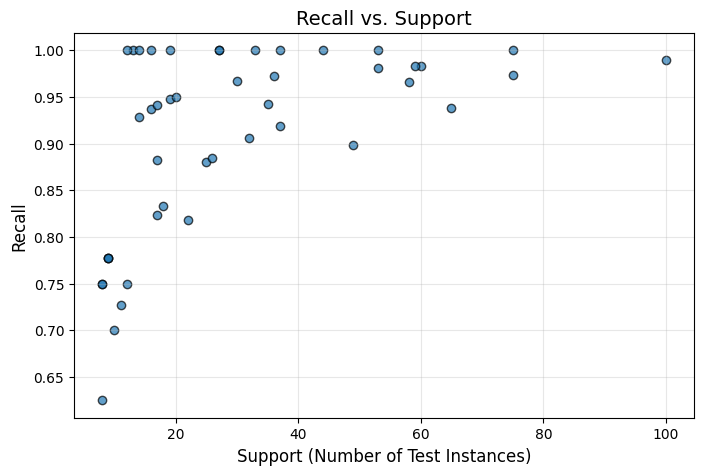

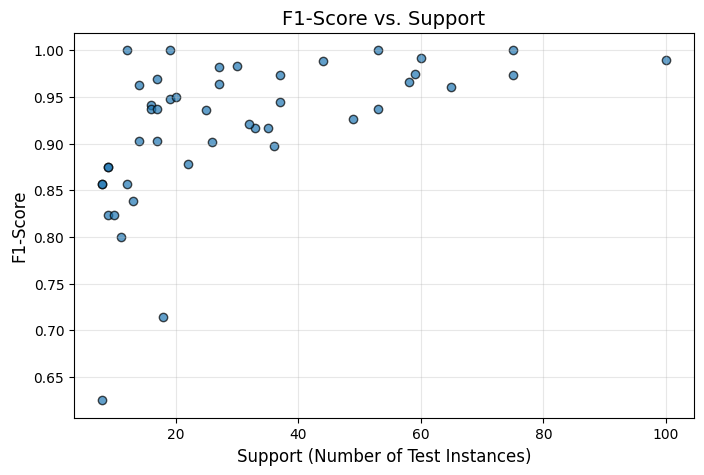

Support  Precision    Recall  F1-Score
Support    1.000000   0.219864  0.532634  0.527671
Precision  0.219864   1.000000  0.148905  0.706796
Recall     0.532634   0.148905  1.000000  0.800827
F1-Score   0.527671   0.706796  0.800827  1.000000

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df = second_level_metrics['genus']

# Plotting support vs. each metric
metrics = ["Precision", "Recall", "F1-Score"]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.scatter(metrics_df["Support"], metrics_df[metric], alpha=0.7, edgecolors='k')
    plt.title(f"{metric} vs. Support", fontsize=14)
    plt.xlabel("Support (Number of Test Instances)", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Display correlations
correlations = metrics_df[["Support", "Precision", "Recall", "F1-Score"]].corr()
correlations

In [ ]:
import tensorflow as tf

# Create a feature extractor model from your trained model
feature_extractor = tf.keras.Model(
    inputs=CV_MODEL.input, 
    #outputs=CV_MODEL.get_layer('global_average_pooling2d').output,
    outputs=CV_MODEL.get_layer('dense_1').output,
)

# Extract features and true labels
features = []
labels = []

for images, batch_labels in test_ds:  # Iterate through your test dataset
    batch_features = feature_extractor(images)  # Extract features
    features.append(batch_features.numpy())
    
    # Extract species labels (or the appropriate level)
    #pred_labels = tf.argmax(batch_labels['family'], axis=1).numpy()
    #labels.append(genus_labels)  # Collect the corresponding true labels

# Convert features and labels to arrays
import numpy as np
features = np.concatenate(features, axis=0)
#labels = np.concatenate(labels, axis=0)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce features to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

labels_names = test_df['species'].to_list()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_ids = le.fit_transform(labels_names)
label_ids

array([ 4, 37, 10, ..., 25, 22, 35])

In [ ]:
component_1 = [item[0] for item in reduced_features]
component_2 = [item[1] for item in reduced_features]

In [ ]:
data = {
    "label_ids": label_ids,
    "component_1": component_1,
    "component_2": component_2,
}

tsne_data = pd.DataFrame(data)

#tsne_data = tsne_data[tsne_data['label_ids'] <= 3]

tsne_data

label_ids  component_1  component_2
0             4    16.667509    16.501999
1            37   -30.304729    -1.441689
2            10    -9.317525   -36.313438
3            23    42.274559    -5.794589
4            50    39.443378    -2.352564
...         ...          ...          ...
1349         10   -37.920708    29.800257
1350         37    -6.296703    34.776840
1351         25   -28.437710    13.831704
1352         22   -29.241627    13.298539
1353         35   -29.402109     2.395497

[1354 rows x 3 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


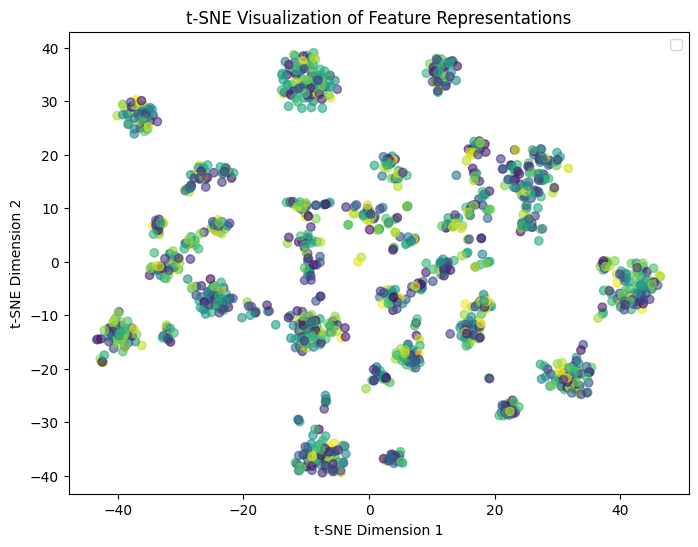

In [ ]:
# Visualize the reduced features
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data['component_1'], tsne_data['component_2'], c=tsne_data['label_ids'], alpha=0.6, cmap='viridis', )

plt.title("t-SNE Visualization of Feature Representations")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_64250/962257814.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


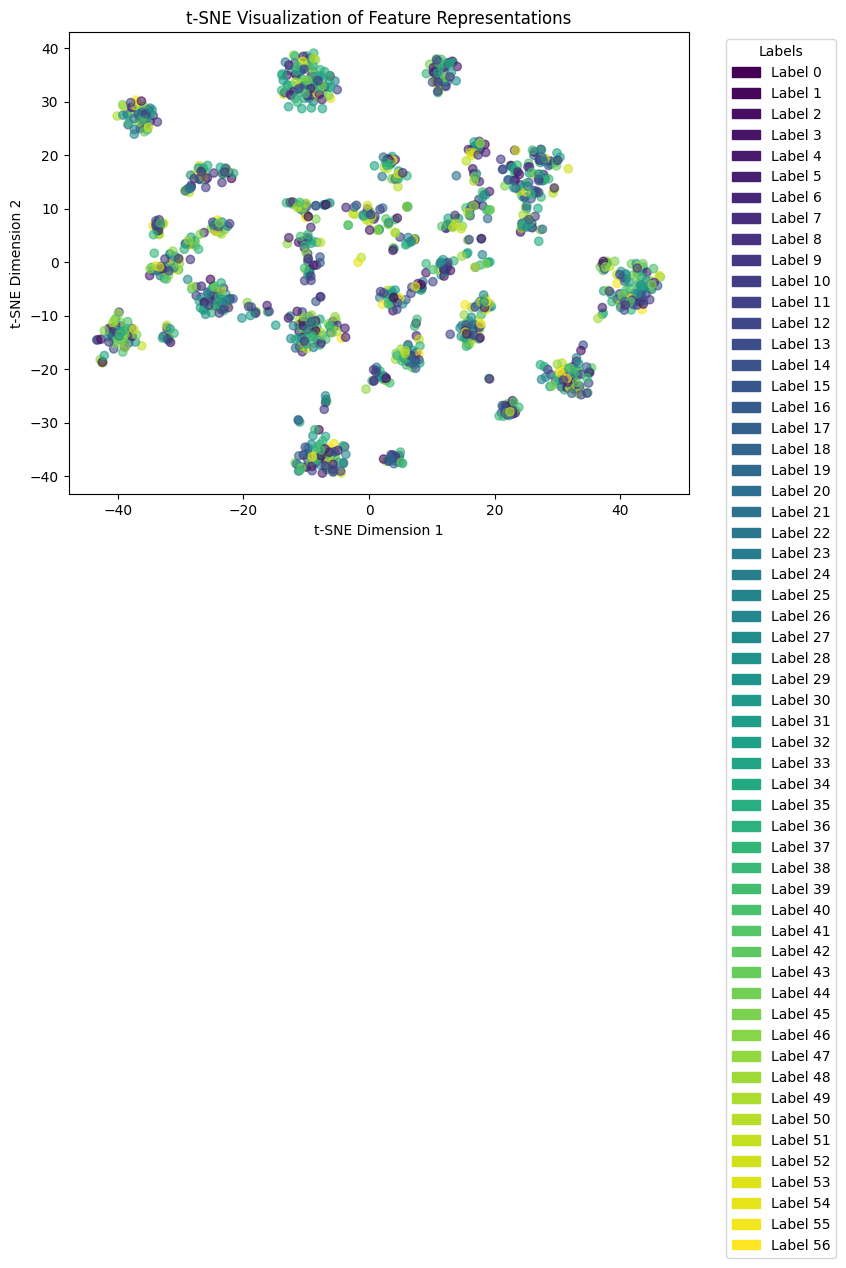

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Example data (replace with your actual data)
np.random.seed(42)
num_points = 1350
num_labels = 57
label_names = [f"Label {i}" for i in range(num_labels)]  # Replace with your actual label names

# Create a colormap with a distinct color for each label
cmap = plt.get_cmap('viridis', num_labels)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    tsne_data['component_1'], 
    tsne_data['component_2'], 
    c=tsne_data['label_ids'], 
    cmap=cmap, 
    alpha=0.6
)

# Create a legend with distinct colors for each label
handles = [
    mpatches.Patch(color=cmap(i), label=label_names[i]) for i in range(num_labels)
]
plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add titles and labels
plt.title("t-SNE Visualization of Feature Representations")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        """
        Initialize Grad-CAM for a model with a specific last convolutional layer
        
        Parameters:
        - model: Trained Keras model
        - last_conv_layer_name: Name of the last convolutional layer to visualize
        """
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name
        
        # Create gradient model
        self.grad_model = self.create_grad_model()
    
    def create_grad_model(self):
        """
        Create a model that outputs the last conv layer's output and the model's output
        """
        # Find the last convolutional layer
        last_conv_layer = self.model.get_layer('resnet50v2').get_layer(self.last_conv_layer_name)
        
        # Create a model with inputs and outputs
        grad_model = tf.keras.models.Model(
            [self.model.get_layer('resnet50v2').inputs], 
            [last_conv_layer.output, self.model.get_layer('resnet50v2').output]
        )
        
        return grad_model
    
    def compute_heatmap(self, img, class_index=None):
        """
        Compute Grad-CAM heatmap
        
        Parameters:
        - img: Input image tensor
        - class_index: Index of class to visualize (if None, uses the predicted class)
        
        Returns:
        - Heatmap of gradients
        """
        # Expand dimensions if needed
        if len(img.shape) == 3:
            img = tf.expand_dims(img, 0)
        
        # Compute gradients
        with tf.GradientTape() as tape:
            conv_outputs = self.grad_model(img)
            predictions = self.model(img)
            
            # Ensure predictions is a tensor
            predictions = predictions[0] if isinstance(predictions, list) else predictions
        
            
            # If no specific class is provided, use the top predicted class
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            
            # Compute the loss for the specific class
            class_output = predictions[:, class_index]
        
        # Get the gradients of the class output with respect to the conv layer output
        grads = tape.gradient(class_output, conv_outputs)
        del tape  # Explicitly delete to free memory
        
        # Global Average Pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Multiply each gradient by its corresponding feature map
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(
            tf.multiply(pooled_grads, conv_outputs), 
            axis=-1
        )
        
        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    def overlay_heatmap(self, original_img, heatmap, alpha=0.4):
        """
        Overlay the heatmap on the original image
        
        Parameters:
        - original_img: Original image
        - heatmap: Computed heatmap
        - alpha: Transparency of the heatmap
        
        Returns:
        - Image with heatmap overlaid
        """
        # Resize heatmap to match image dimensions
        heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        
        # Apply color map
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        # Convert image to uint8 if needed
        if original_img.dtype == np.float32 or original_img.dtype == np.float64:
            original_img = (original_img * 255).astype(np.uint8)
        elif original_img.dtype != np.uint8:
            original_img = original_img.astype(np.uint8)
        
        # Overlay heatmap
        superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
        return superimposed_img
    
    def plot_grad_cam(self, img, class_index=None, alpha=0.4):
        """
        Visualize Grad-CAM
        
        Parameters:
        - img: Input image
        - class_index: Class to visualize (optional)
        - alpha: Heatmap transparency
        """
        # Compute heatmap
        heatmap = self.compute_heatmap(img, class_index)
        
        # Overlay heatmap
        superimposed_img = self.overlay_heatmap(
            original_img=img[0] if len(img.shape) == 4 else img, 
            heatmap=heatmap, 
            alpha=alpha
        )
        
        # Plot results
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(img[0] if len(img.shape) == 4 else img)
        plt.axis('off')
        
        plt.subplot(132)
        plt.title('Grad-CAM Heatmap')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')
        
        plt.subplot(133)
        plt.title('Grad-CAM Overlay')
        plt.imshow(superimposed_img)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage
def prepare_grad_cam(model, test_data, layer_name):
    """
    Helper function to prepare Grad-CAM visualization
    
    Parameters:
    - model: Trained Keras model
    - test_data: Test dataset or image
    - layer_name: Name of the last convolutional layer
    
    Returns:
    - Grad-CAM instance
    """
    # Create Grad-CAM instance
    grad_cam = GradCAM(model, layer_name)
    
    return grad_cam

In [6]:
# Assuming CV_MODEL is your model and 'your_conv_layer_name' is the target layer
grad_cam = GradCAM(CV_MODEL, 'conv5_block3_out')

In [ ]:
# For a single image from your test dataset
for batch in test_ds.take(1):
    image, label = batch
    grad_cam.plot_grad_cam(image)

In [1]:
# Example with PyTorch Grad-CAM (if using PyTorch)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

cam = GradCAM(model=model, target_layer=model.layer4[-1])  # Example layer
grayscale_cam = cam(input_tensor=input_tensor, targets=[YourTargetCategory])
visualization = show_cam_on_image(rgb_image, grayscale_cam[0, :], use_rgb=True)
plt.imshow(visualization)
plt.show()


ModuleNotFoundError: No module named 'pytorch_grad_cam'